<div style="width: 100%; overflow: hidden;">
    <div style="width: 150px; float: left;"> <img src="data/D4Sci_logo_ball.png" alt="Data For Science, Inc" align="left" border="0"> </div>
    <div style="float: left; margin-left: 10px;"> <h1>CoVID-19</h1>
<h1>Visualizing the official data</h1>
        <p>Bruno Gonçalves<br/>
        <a href="http://www.data4sci.com/">www.data4sci.com</a><br/>
            @bgoncalves, @data4sci</p></div>
</div>

In [1]:
from collections import Counter
from pprint import pprint

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt 
import matplotlib.patches as mpatches
from matplotlib.collections import PatchCollection

import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature

import warnings
warnings.filterwarnings("ignore")

import watermark

%load_ext watermark
%matplotlib inline

We start by print out the versions of the libraries we're using for future reference

In [2]:
%watermark -n -v -m -g -iv

matplotlib 3.1.3
watermark  2.0.2
json       2.0.9
numpy      1.18.1
pandas     1.0.1
cartopy    0.18.0
autopep8   1.5
Sun Jun 28 2020 

CPython 3.7.3
IPython 6.2.1

compiler   : Clang 4.0.1 (tags/RELEASE_401/final)
system     : Darwin
release    : 19.5.0
machine    : x86_64
processor  : i386
CPU cores  : 8
interpreter: 64bit
Git hash   : 951418a56f37621cd2a1ce26f915057f41a98f83


Load default figure style

In [3]:
plt.style.use('./d4sci.mplstyle')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

## Johns Hopkins University Dataset

The JHU CoVID dataset has steadly become the unofficial standard dataset for the number of cases and deaths aroudn the world. You can download the continuously updated data from their [github repository](https://github.com/CSSEGISandData/COVID-19/):

In [4]:
url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/'

The repository contains 4 time series files:

- time_series_covid19_confirmed_global.csv
- time_series_covid19_deaths_global.csv
- time_series_covid19_confirmed_US.csv
- time_series_covid19_deaths_US.csv

correponding to confirmed cases and number of deaths globally by country and for the US by state.

These curated files result from an aggregation and standardization of several dozen national health authority reports and have become the go-to 

## Global data

We start by looking at the totals for confirmed cases and deaths around the world

In [5]:
confirmed = pd.read_csv(url + 'time_series_covid19_confirmed_global.csv')
deaths = pd.read_csv(url + 'time_series_covid19_deaths_global.csv')

The dataset include not only the number of total cases (or deaths) by country for eah day, but also state and province level information (in some cases), as well as Latitude and Longitude data:

In [6]:
confirmed.head()

Province/State Country/Region      Lat     Long  1/22/20  1/23/20  1/24/20  \
0            NaN    Afghanistan  33.0000  65.0000        0        0        0   
1            NaN        Albania  41.1533  20.1683        0        0        0   
2            NaN        Algeria  28.0339   1.6596        0        0        0   
3            NaN        Andorra  42.5063   1.5218        0        0        0   
4            NaN         Angola -11.2027  17.8739        0        0        0   

   1/25/20  1/26/20  1/27/20  ...  6/18/20  6/19/20  6/20/20  6/21/20  \
0        0        0        0  ...    27532    27878    28424    28833   
1        0        0        0  ...     1788     1838     1891     1962   
2        0        0        0  ...    11385    11504    11631    11771   
3        0        0        0  ...      855      855      855      855   
4        0        0        0  ...      166      172      176      183   

   6/22/20  6/23/20  6/24/20  6/25/20  6/26/20  6/27/20  
0    29157    29481    29640    30175    30451    30616  
1     1995     2047     2114     2192     2269     2330  
2    11920    12076    12248    12445    12685    12968  
3      855      855      855      855      855      855  
4      186      189      197      212      212      259  

[5 rows x 162 columns]

So we can easily see how the the disease has spread to the four corners of the world.

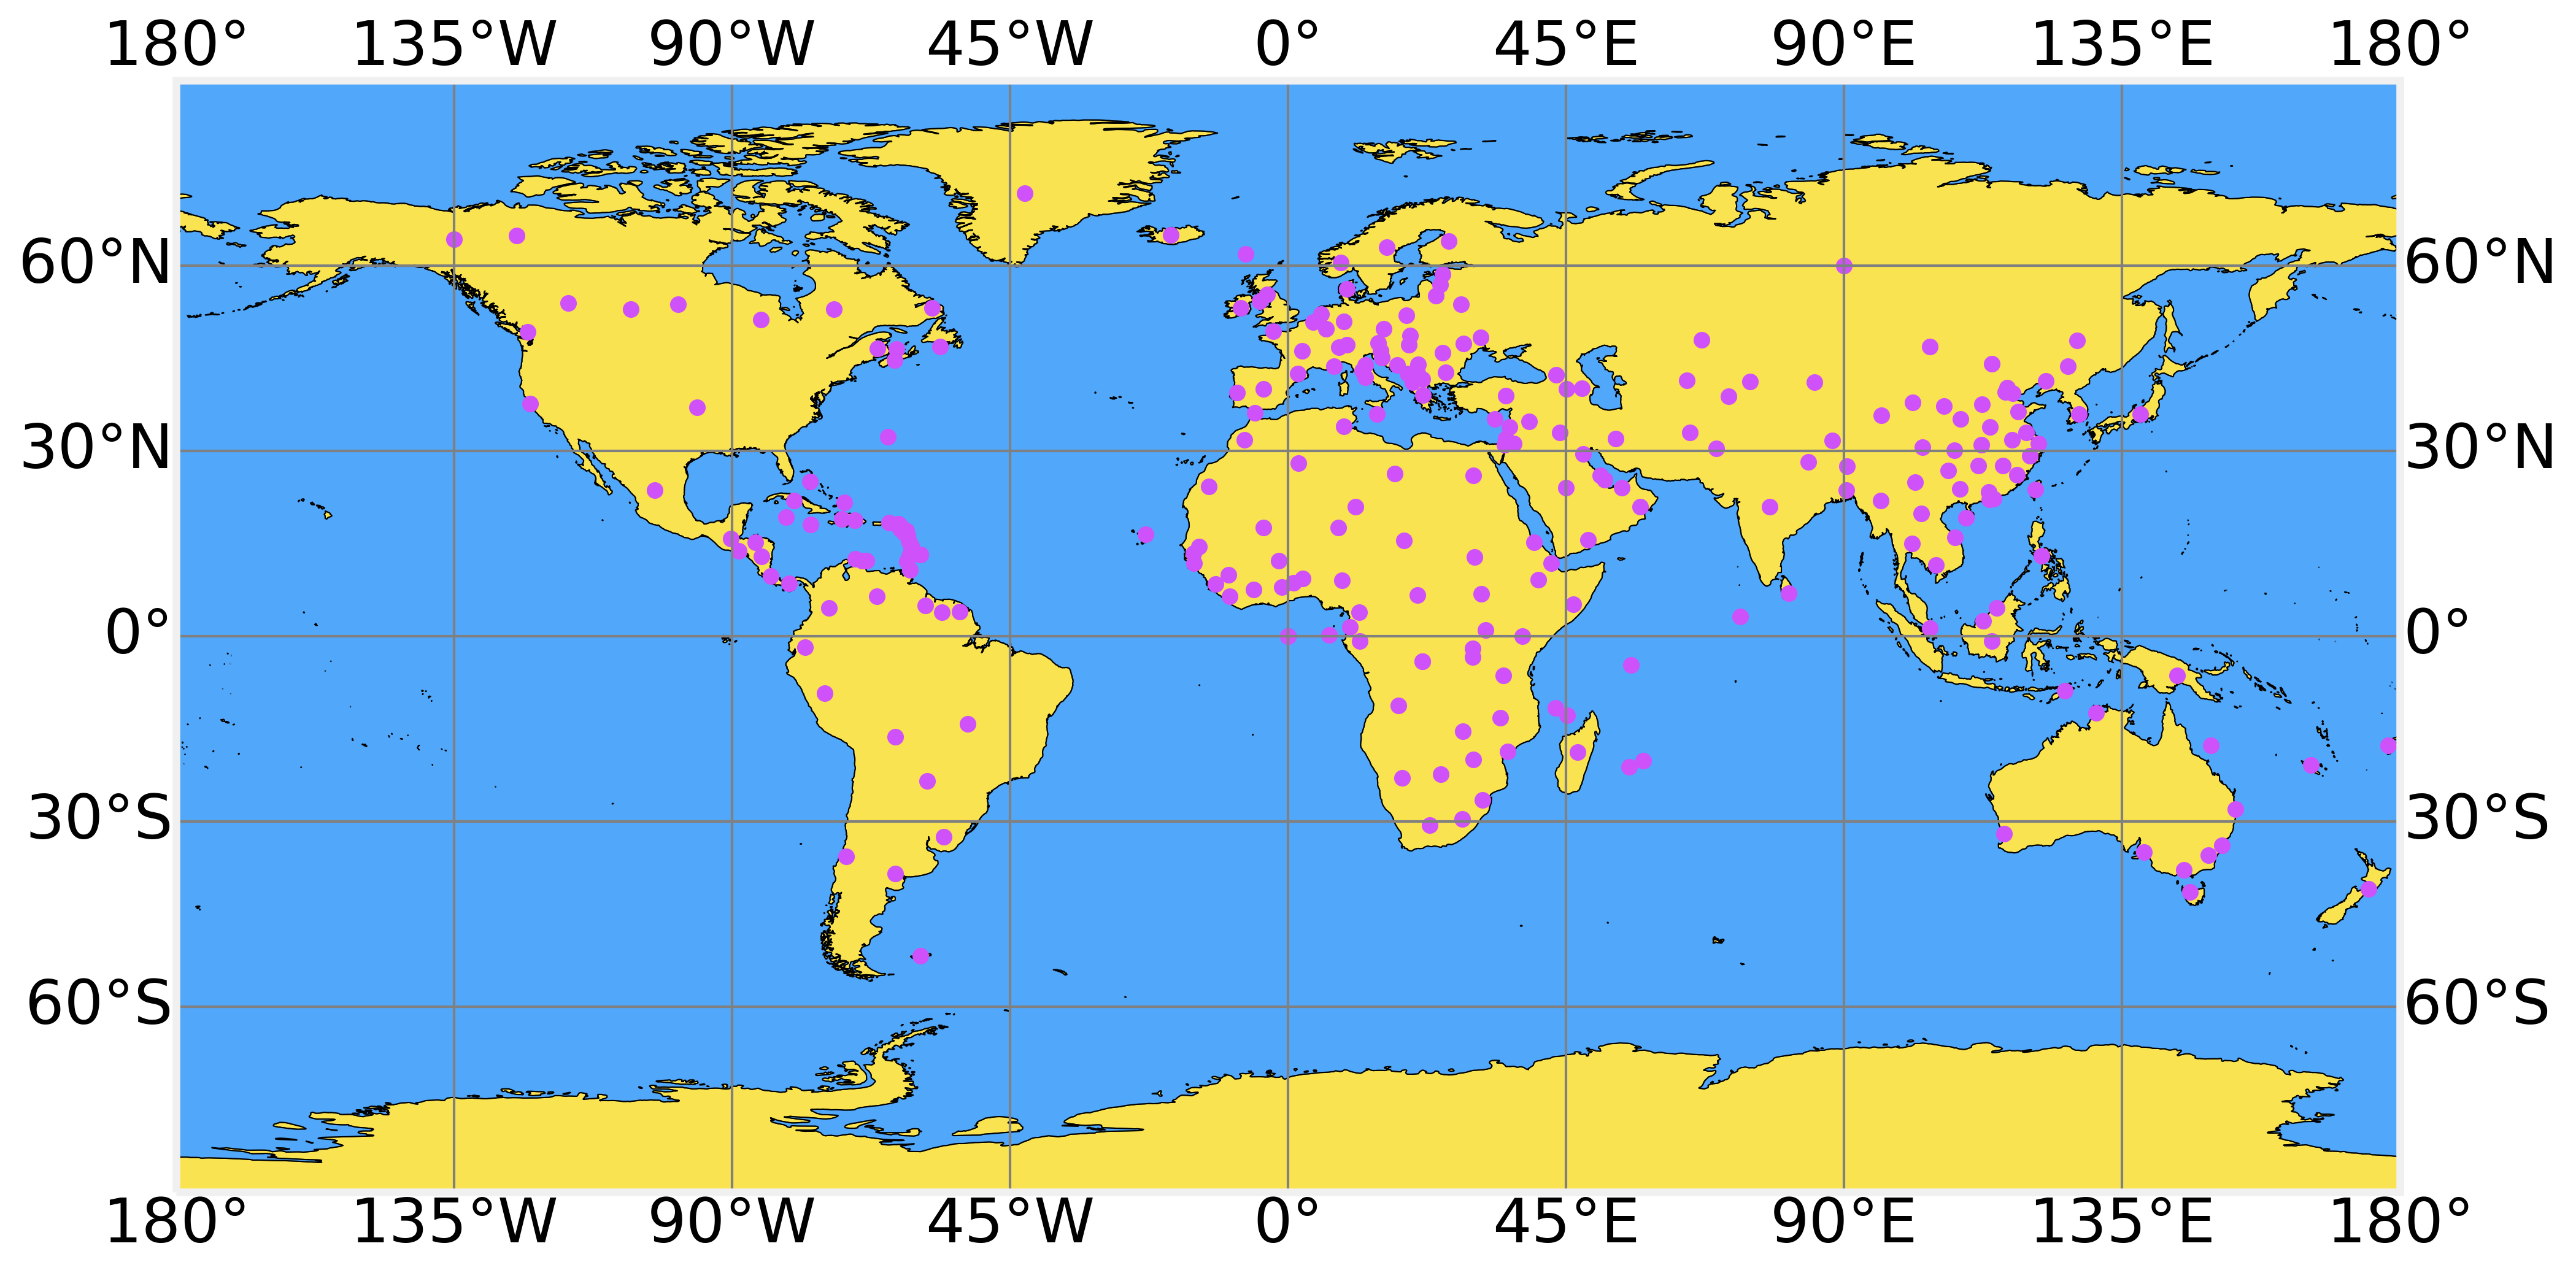

In [7]:
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_global()
ax.coastlines()

ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor='k', facecolor=colors[4]))
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'ocean', '50m', edgecolor='k', facecolor=colors[0]))
ax.scatter(x=confirmed.Long, y=confirmed.Lat, zorder=2, color=colors[1])

ax.gridlines(draw_labels=True, dms=True, 
             xlocs=np.arange(-180, 180.1, 45), 
             ylocs=np.arange(-90, 90.1, 30),
             x_inline=False, y_inline=False, color='gray')

plt.tight_layout()

We can obtain the country totals by aggregating over all the regions. The easiest way to do this is to remove the extraneous columns and sum by column

In [8]:
del_columns = [
 'Province/State',
 'Lat',
 'Long',
]

For convenience, we also transpose the data so that each row corresponds to a specific date. This will make it easier to select specific countries for plotting

In [9]:
confirmed_timeline = confirmed.drop(columns=del_columns).groupby('Country/Region').sum().T
deaths_timeline = deaths.drop(columns=del_columns).groupby('Country/Region').sum().T

In order to take full advantage of Pandas time series support we convert the dates to datetime format:

In [10]:
confirmed_timeline.index = pd.to_datetime(confirmed_timeline.index)
deaths_timeline.index = pd.to_datetime(deaths_timeline.index)

In total we have information about 188 countries, and we can easily see how quickly the virus has spread around the world

Text(0, 0.5, 'Number of countries and Regions')

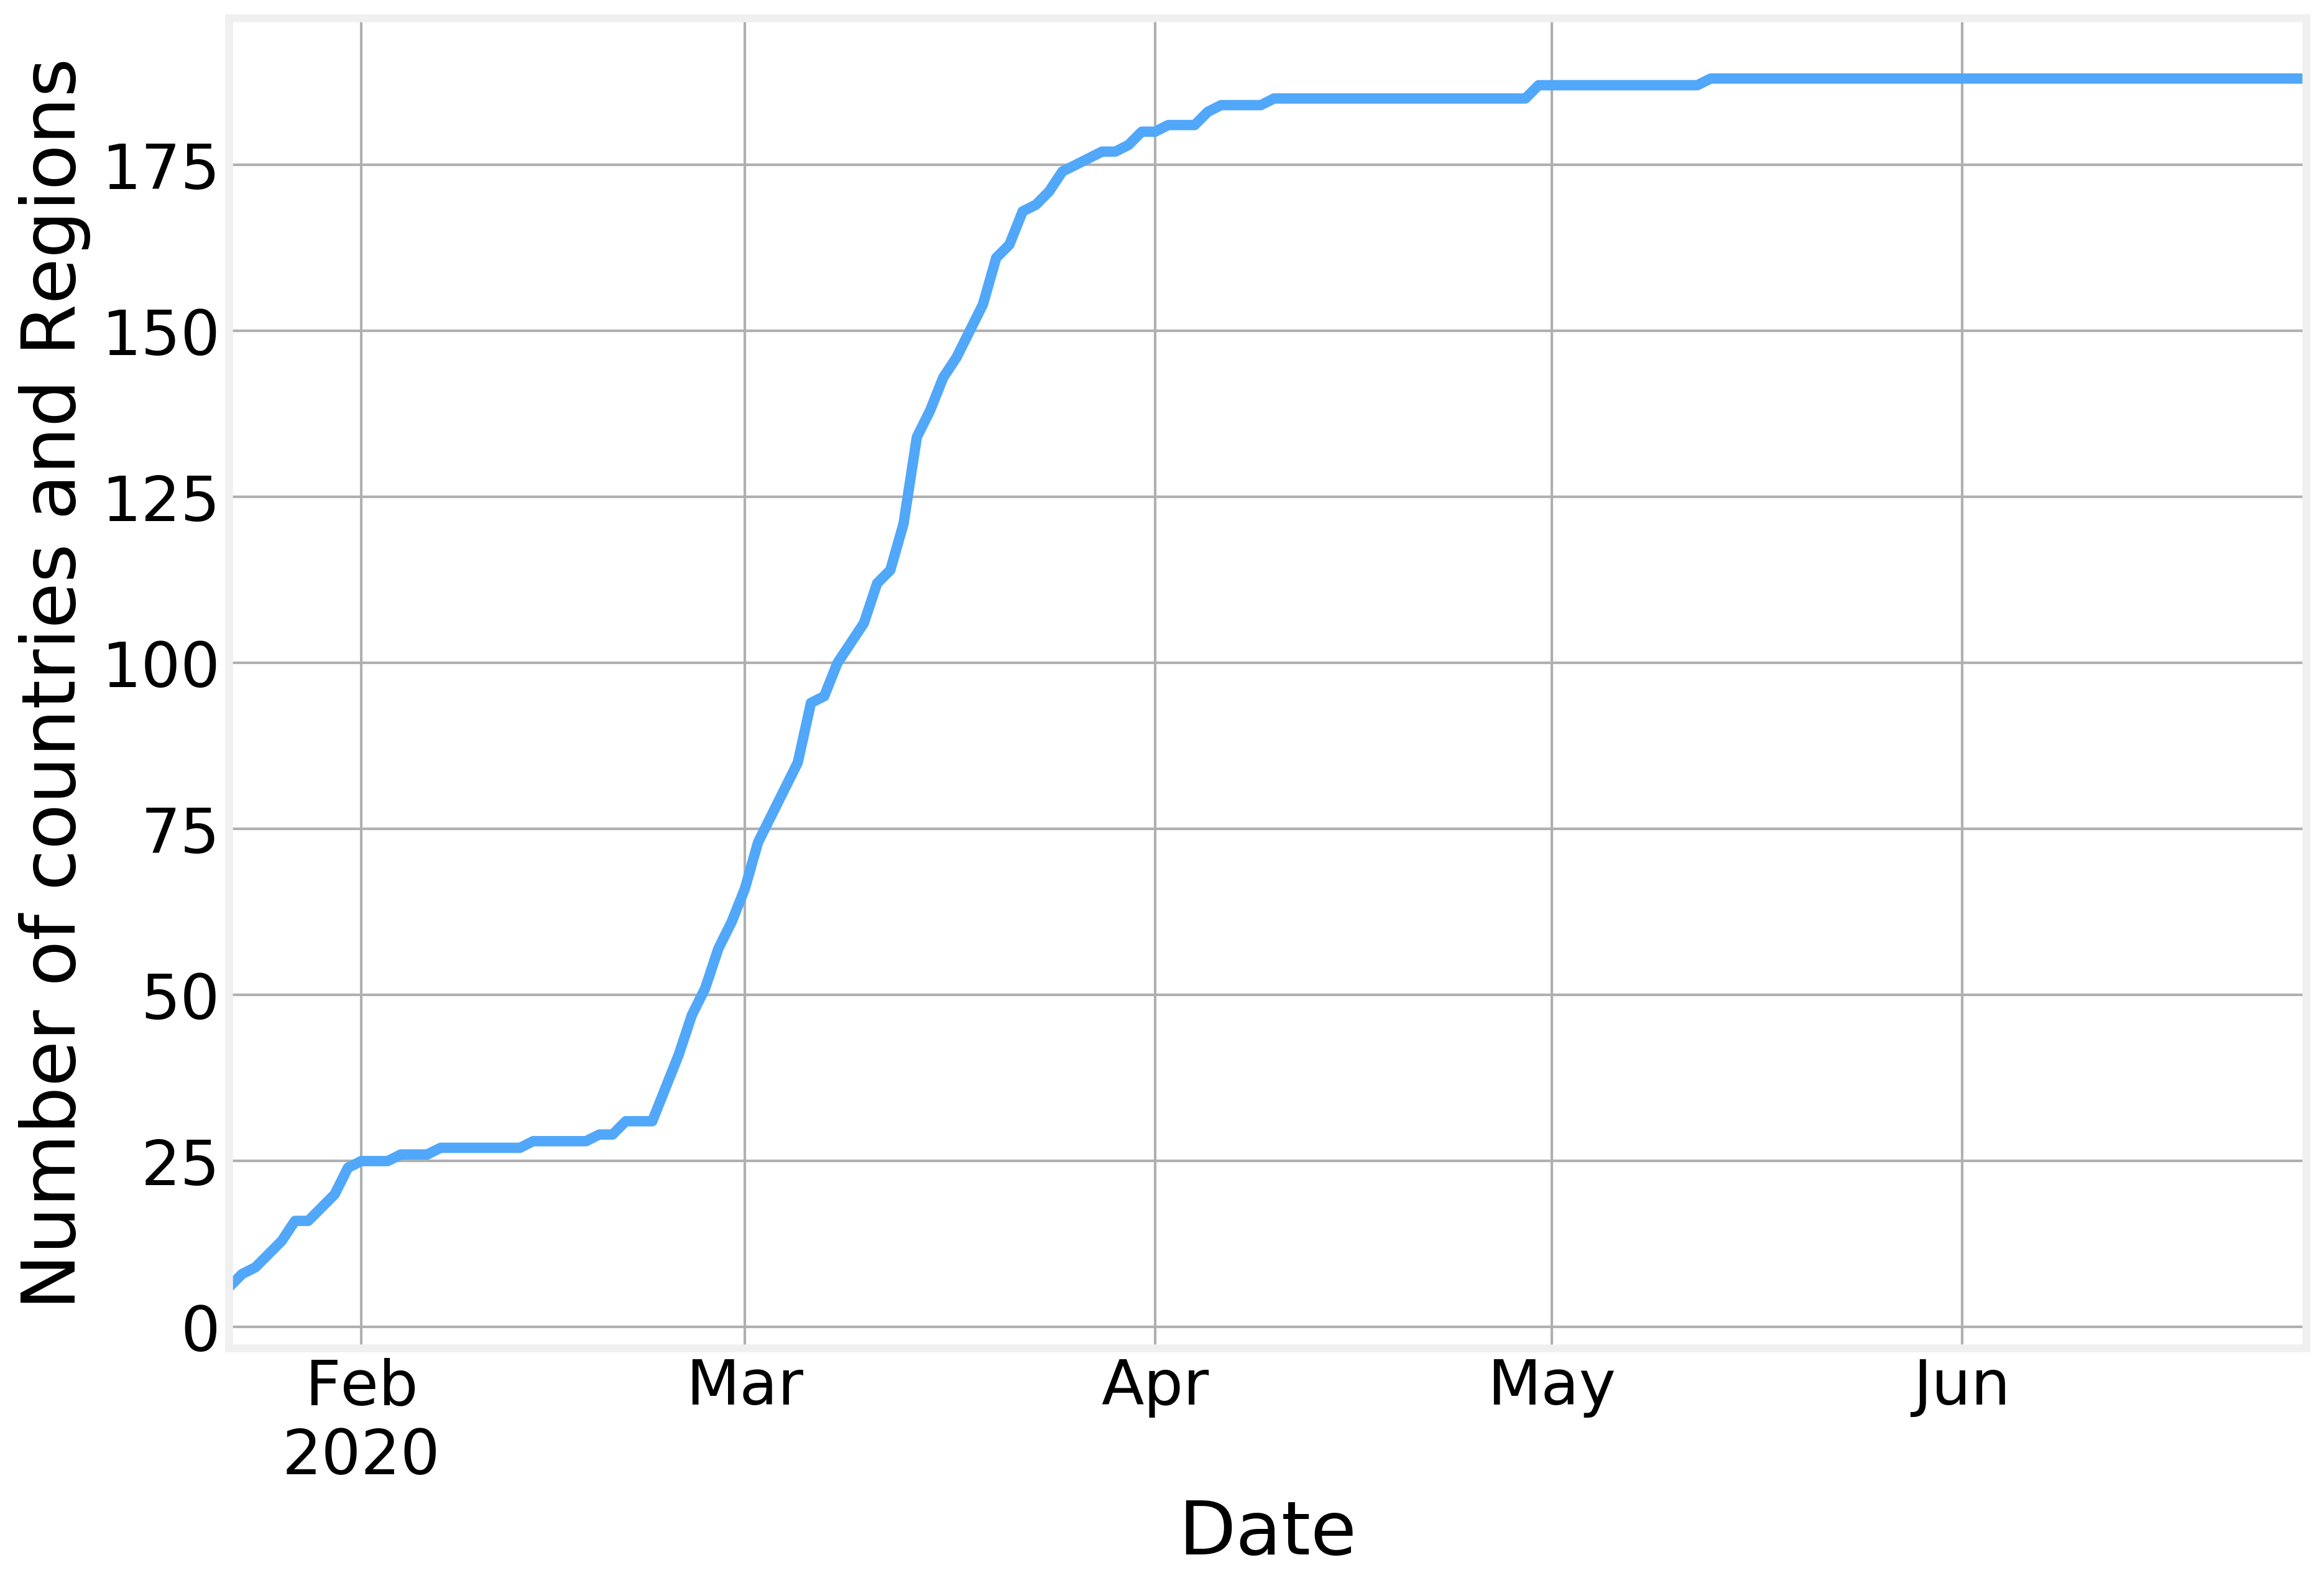

In [11]:
ax = (confirmed_timeline>0).sum(axis=1).plot()
ax.set_xlabel('Date')
ax.set_ylabel('Number of countries and Regions')

Where we identify 4 distinct phases:

Text(0, 0.5, 'Number of Countries and Regions')

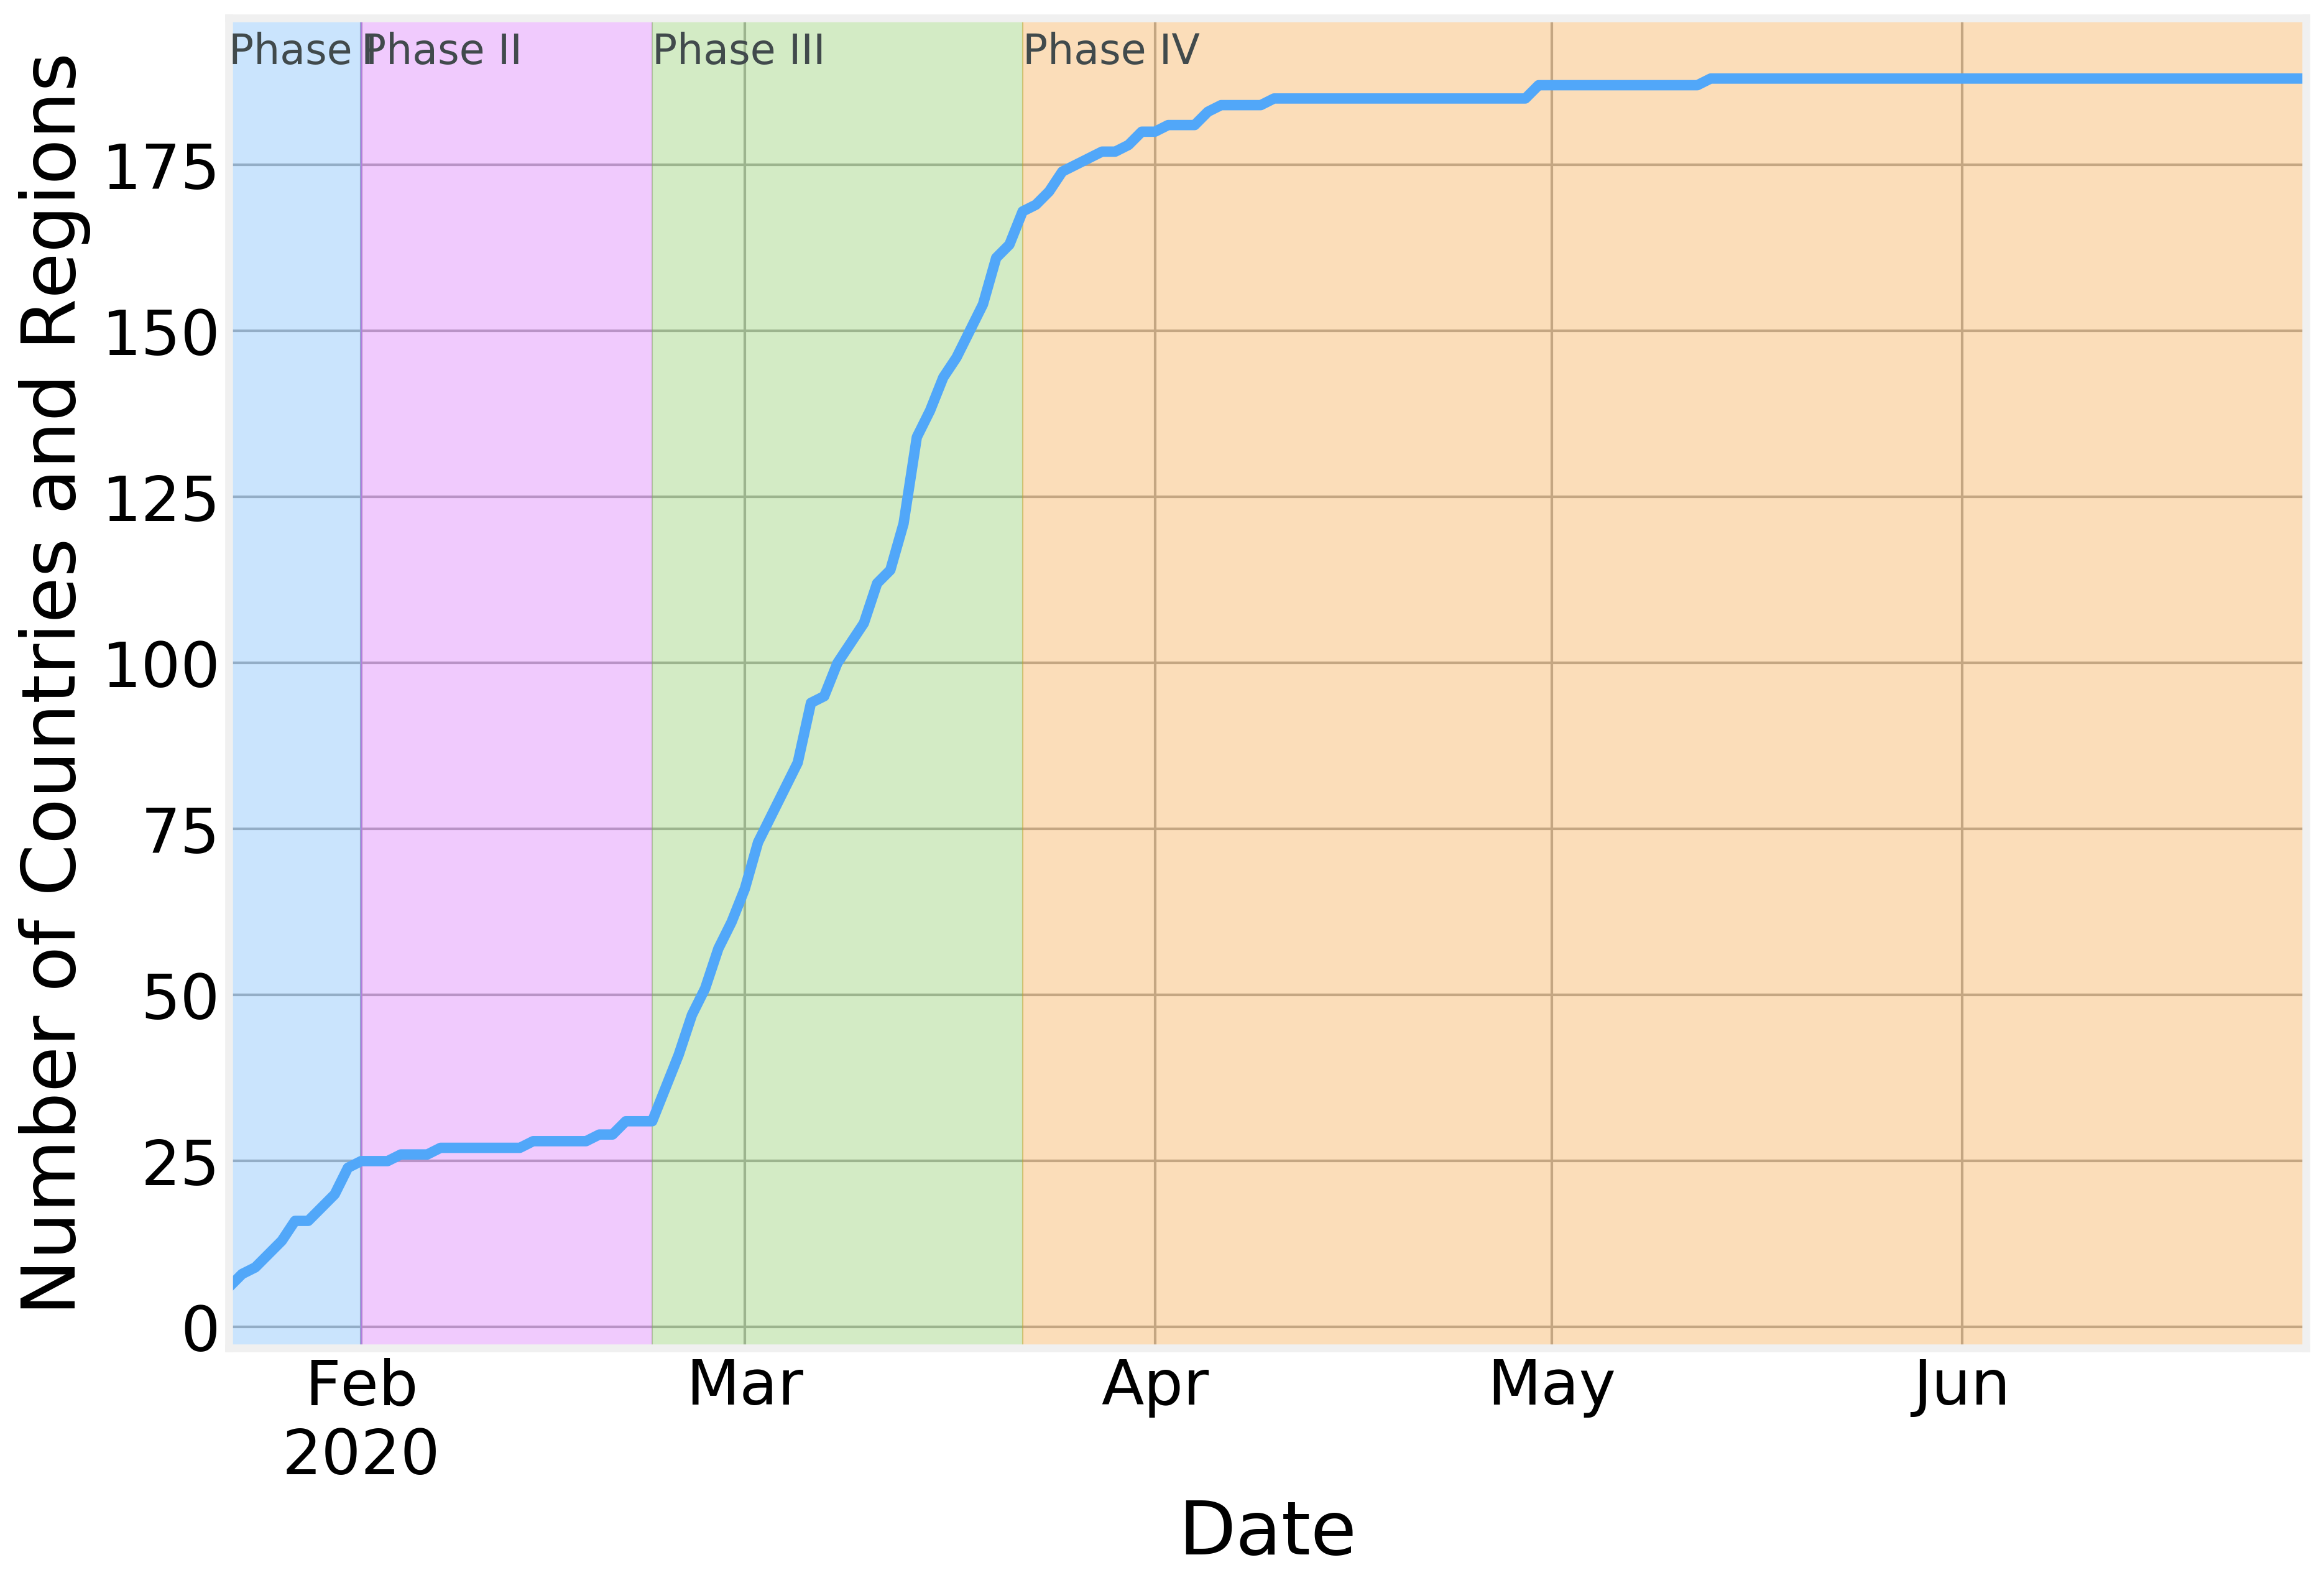

In [12]:
ax = (confirmed_timeline>0).sum(axis=1).plot()

ymin, ymax = ax.get_ylim()
ax.axvspan(xmin=confirmed_timeline.index.min(), xmax='2020-02-01', ymin=ymin, ymax=ymax, color=colors[0], alpha=.3)
ax.axvspan(xmin='2020-02-01', xmax='2020-02-23', ymin=ymin, ymax=ymax, color=colors[1], alpha=.3)
ax.axvspan(xmin='2020-02-23', xmax='2020-03-22', ymin=ymin, ymax=ymax, color=colors[2], alpha=.3)
ax.axvspan(xmin='2020-03-22', xmax=confirmed_timeline.index.max(), ymin=ymin, ymax=ymax, color=colors[3], alpha=.3)
ax.set_ylim(ymin, ymax)

ax.text(x=confirmed_timeline.index.min(), y=ymax-2, s='Phase I', fontsize=16, va='top', color='#414A4C')
ax.text(x='2020-02-01', y=ymax-2, s='Phase II', fontsize=16, va='top', color='#414A4C')
ax.text(x='2020-02-23', y=ymax-2, s='Phase III', fontsize=16, va='top', color='#414A4C')
ax.text(x='2020-03-22', y=ymax-2, s='Phase IV', fontsize=16, va='top', color='#414A4C')


ax.set_xlabel('Date')
ax.set_ylabel('Number of Countries and Regions')

We can easily identify the date when the first case was reported. Unfortunately, the dataset starts on Jan 22 so that's the earliest date we are able to obtain. Fortunately, there are only 6 countries where the first case occured before then

In [13]:
start_dates = pd.DataFrame(confirmed_timeline.apply(lambda x:x[x>0].dropna().idxmin()).sort_values())
start_dates.columns = ['First Case']

The countries in this first phase were located mostly in Asia or had strong connections with China

In [14]:
start_dates[start_dates<='2020-02-01'].dropna()

First Case
Country/Region                 
China                2020-01-22
US                   2020-01-22
Thailand             2020-01-22
Taiwan*              2020-01-22
Japan                2020-01-22
Korea, South         2020-01-22
Vietnam              2020-01-23
Singapore            2020-01-23
France               2020-01-24
Nepal                2020-01-25
Malaysia             2020-01-25
Canada               2020-01-26
Australia            2020-01-26
Germany              2020-01-27
Cambodia             2020-01-27
Sri Lanka            2020-01-27
Finland              2020-01-29
United Arab Emirates 2020-01-29
India                2020-01-30
Philippines          2020-01-30
Sweden               2020-01-31
Italy                2020-01-31
United Kingdom       2020-01-31
Russia               2020-01-31
Spain                2020-02-01

On the second stage, the disease seemed to be relatively contained within just a few countries and with limited spread to new locations. In these 3 weeks, it spread to just 5 new countries (plus the Diamond Princess cruise ship)

In [15]:
start_dates[(start_dates>'2020-02-01') & (start_dates<='2020-02-23')].dropna()

First Case
Country/Region             
Belgium          2020-02-04
Diamond Princess 2020-02-07
Egypt            2020-02-14
Iran             2020-02-19
Israel           2020-02-21
Lebanon          2020-02-21

The third stage was when it trully spread worldwide, we 4-5 new countries reporting cases each day

In [16]:
start_dates[(start_dates>'2020-02-23') & (start_dates<= '2020-03-22')]\
            .dropna().reset_index().groupby('First Case').count().sort_index()

Country/Region
First Case                
2020-02-24               5
2020-02-25               5
2020-02-26               6
2020-02-27               4
2020-02-28               6
2020-02-29               4
2020-03-01               5
2020-03-02               7
2020-03-03               4
2020-03-04               4
2020-03-05               4
2020-03-06               9
2020-03-07               1
2020-03-08               5
2020-03-09               3
2020-03-10               3
2020-03-11               6
2020-03-12               2
2020-03-13               7
2020-03-14              13
2020-03-15               4
2020-03-16               5
2020-03-17               3
2020-03-18               4
2020-03-19               4
2020-03-20               7
2020-03-21               2
2020-03-22               5

Finally, Phase IV was when the final smaller and more isolated countries became infected as well

In [17]:
start_dates[(start_dates>'2020-03-22')].dropna()

First Case
Country/Region                  
Belize                2020-03-23
Laos                  2020-03-24
Libya                 2020-03-24
Mali                  2020-03-25
Saint Kitts and Nevis 2020-03-25
Guinea-Bissau         2020-03-25
Kosovo                2020-03-26
Burma                 2020-03-27
MS Zaandam            2020-03-28
Botswana              2020-03-30
Sierra Leone          2020-03-31
Burundi               2020-03-31
Malawi                2020-04-02
Western Sahara        2020-04-05
South Sudan           2020-04-05
Sao Tome and Principe 2020-04-06
Yemen                 2020-04-10
Tajikistan            2020-04-30
Comoros               2020-04-30
Lesotho               2020-05-13

## Country level analysis

Now we can select specific countries easily. For example, to get a quick plot the totals for the US we must simply do:

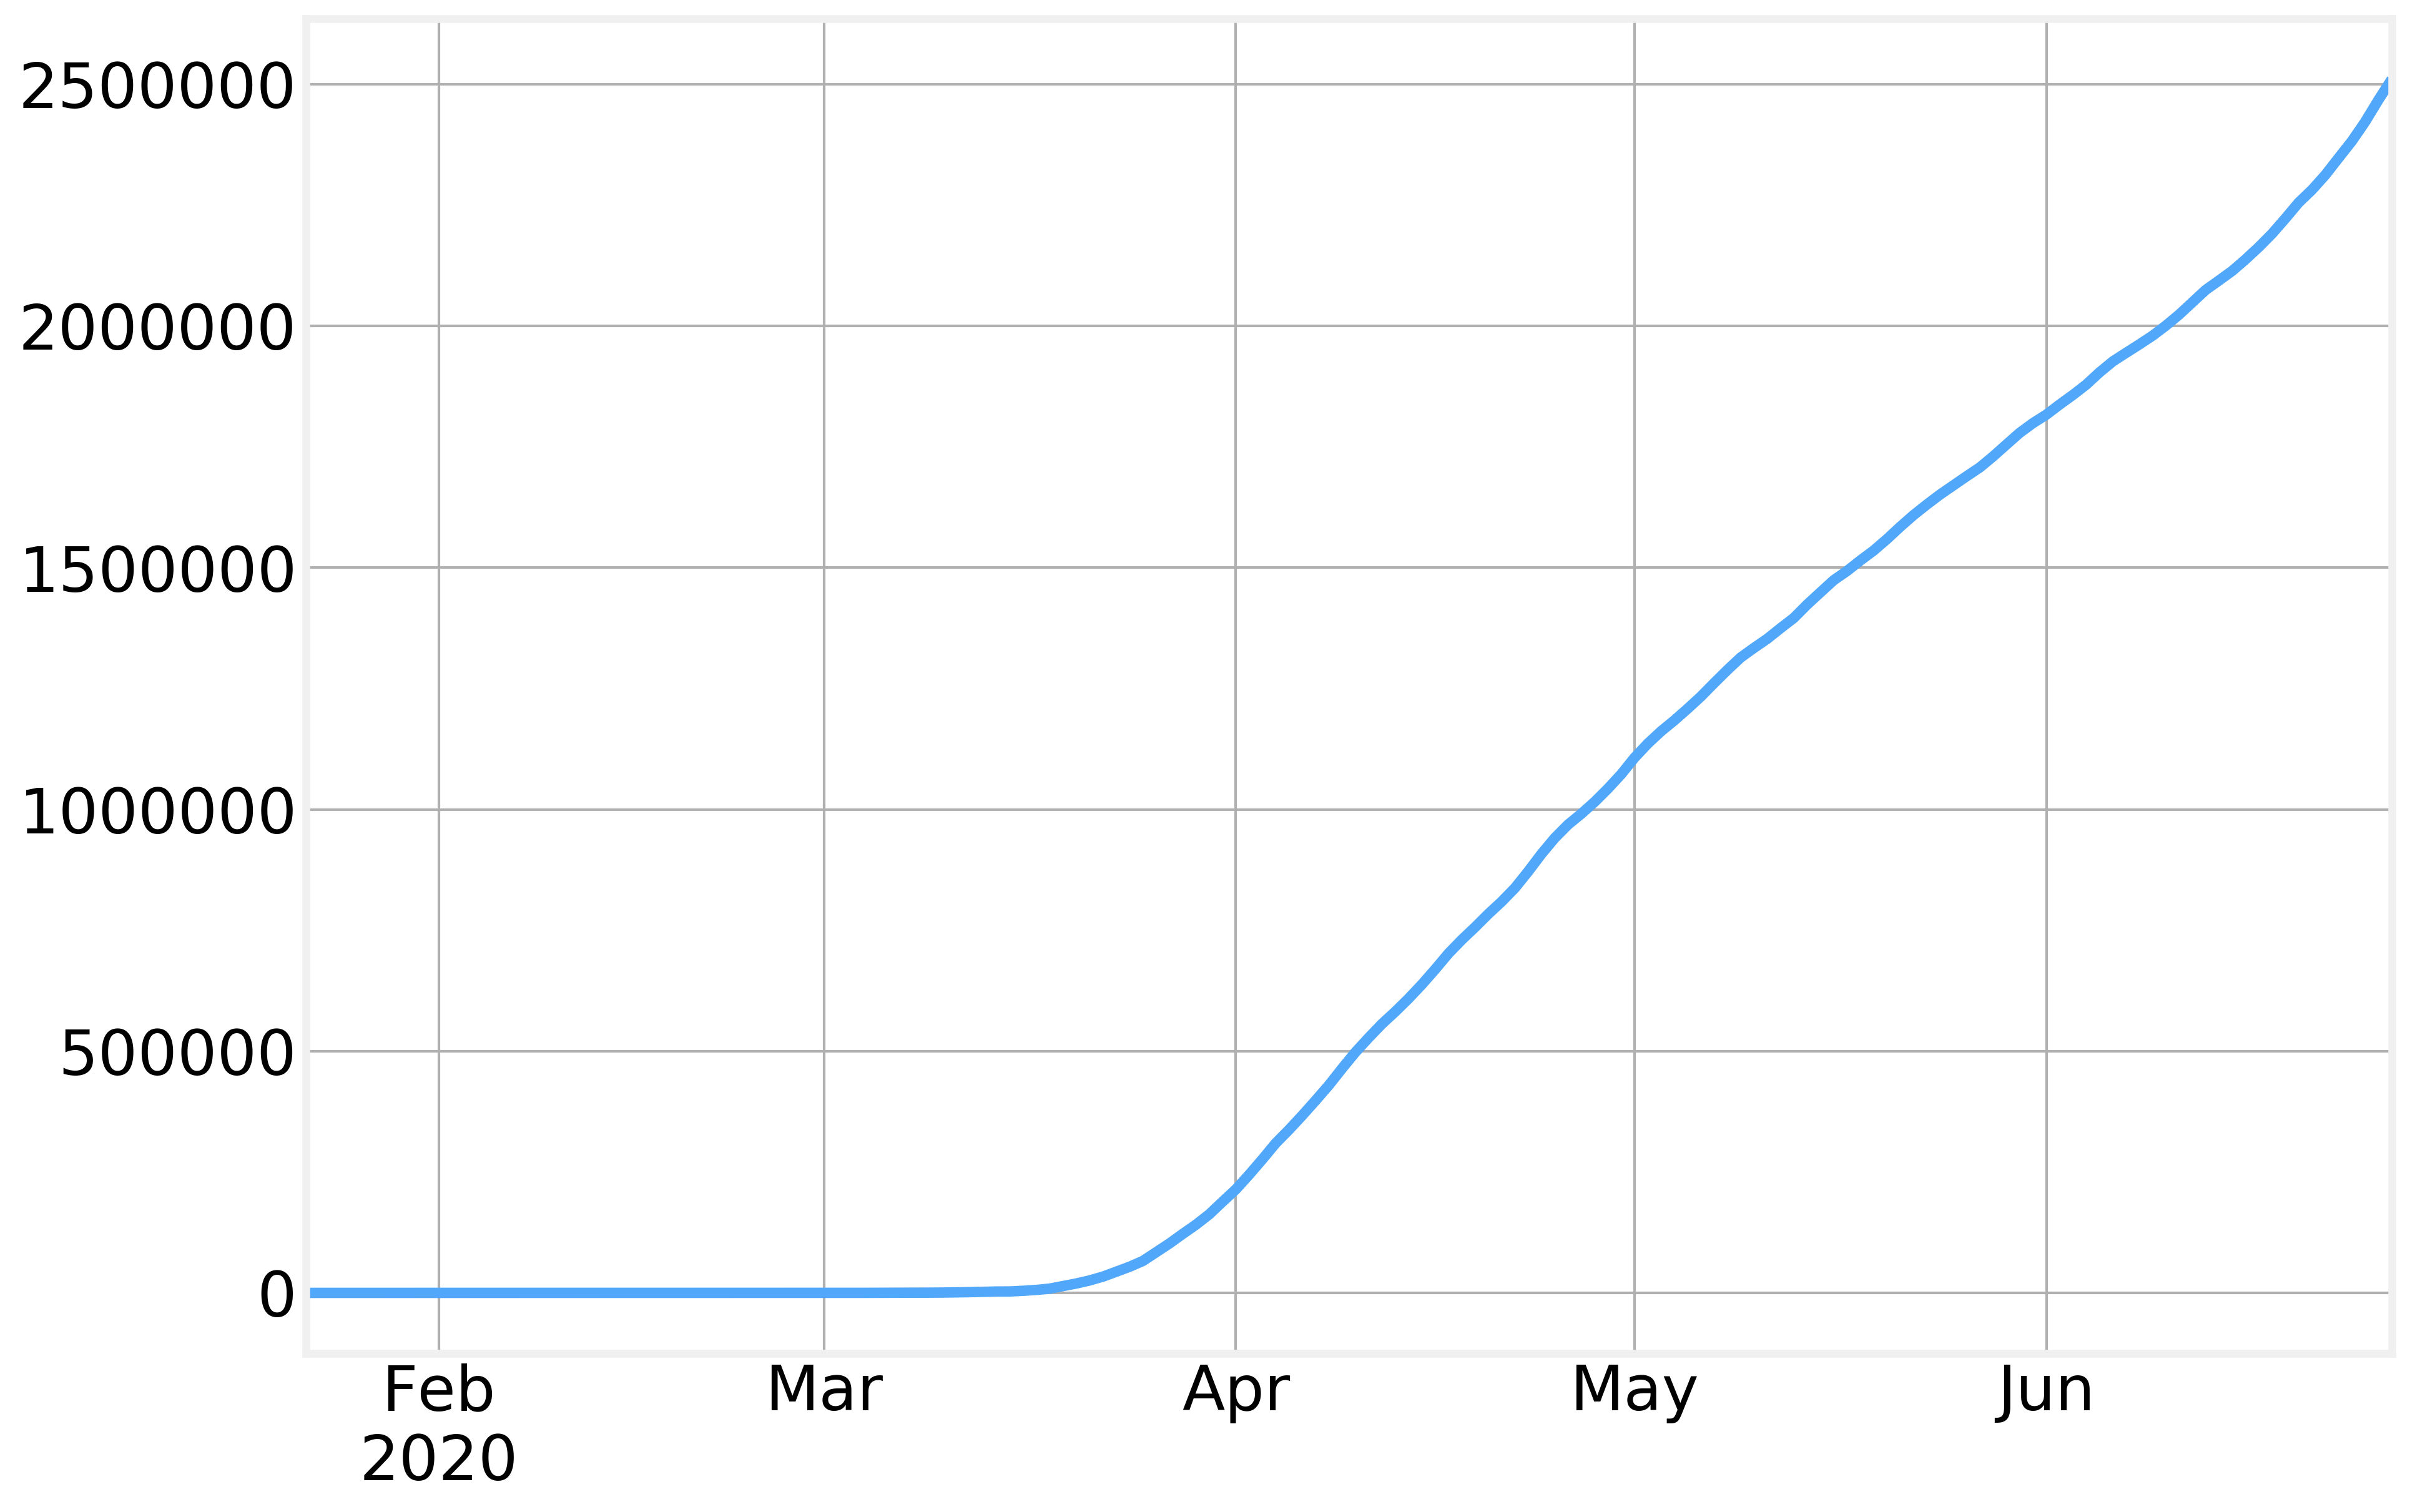

In [18]:
confirmed_timeline['US'].plot()

### United States

As we can see, the data includes only the comulative number of cases. We can obtain the daily numbers by taking the day to day differences

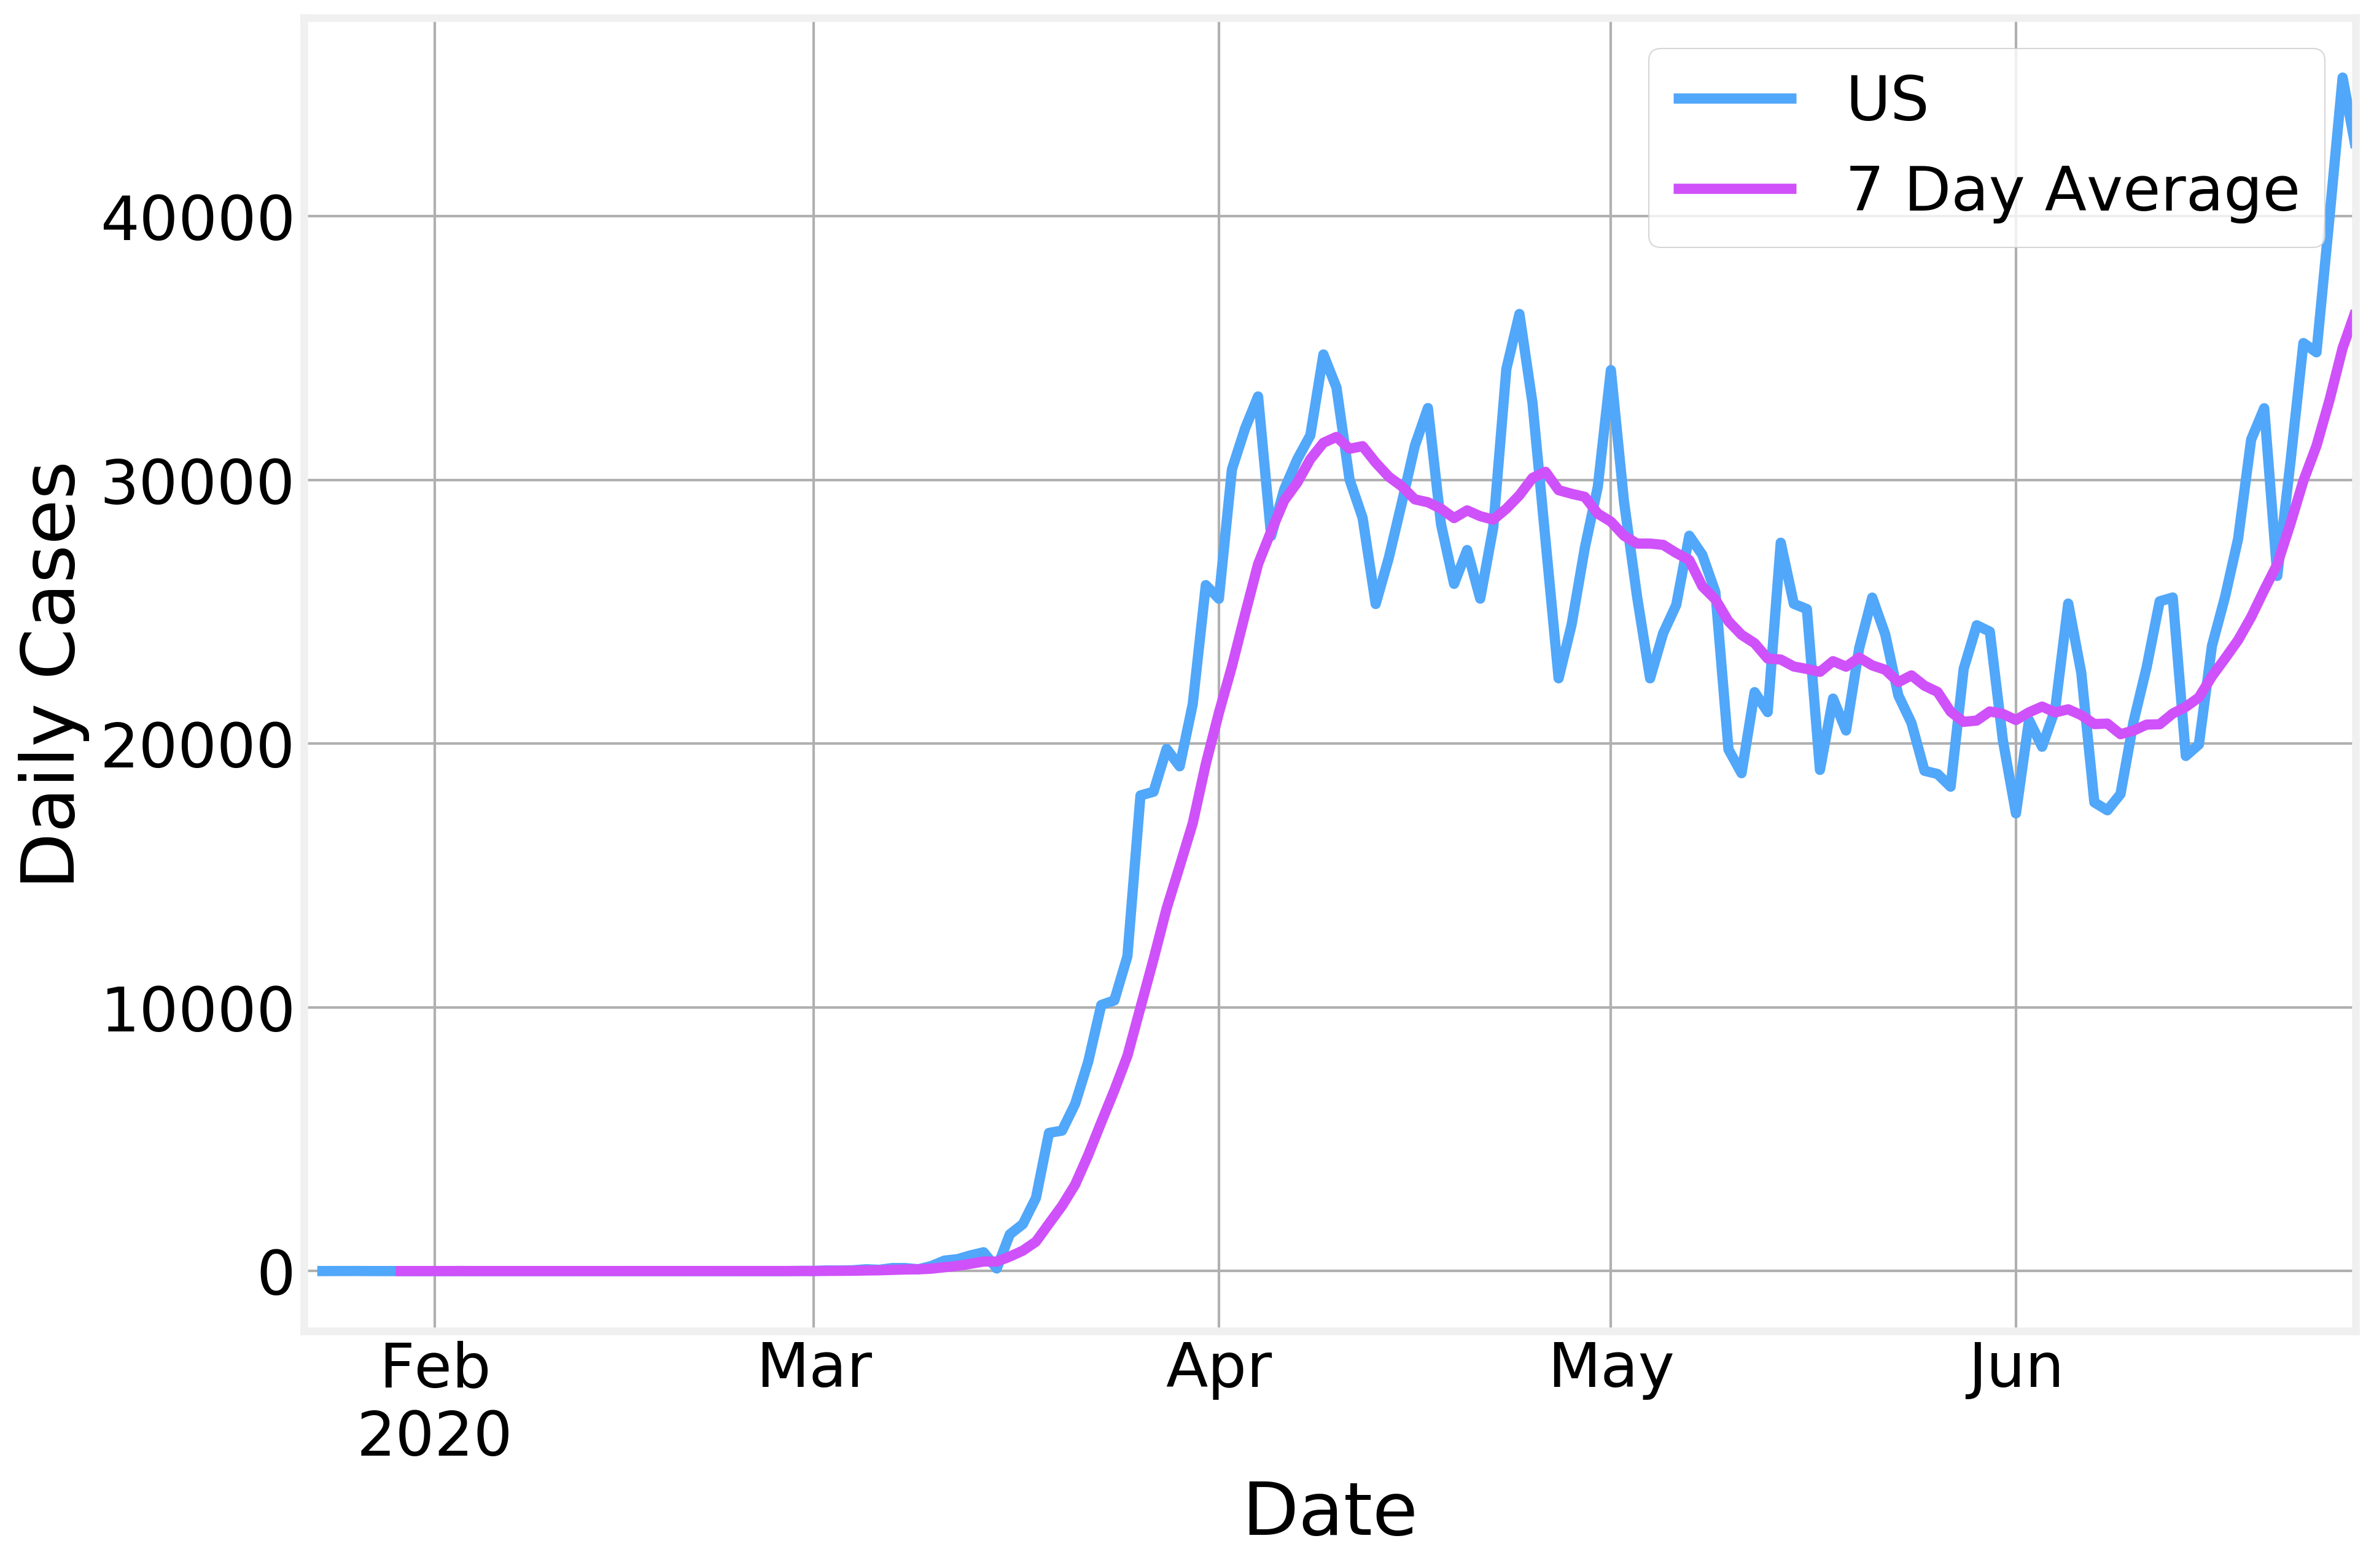

In [19]:
ax = confirmed_timeline['US'].diff(1).plot()
confirmed_timeline['US'].diff(1).rolling(7).mean().plot(ax=ax, label='7 Day Average')
ax.set_xlabel('Date')
ax.set_ylabel('Daily Cases')
ax.legend()

This data is naturally noisy due to issues in coordinating the values reported by the various regions and institutions. We can obtain a cleaner picture by taking a rolling 7 day average:

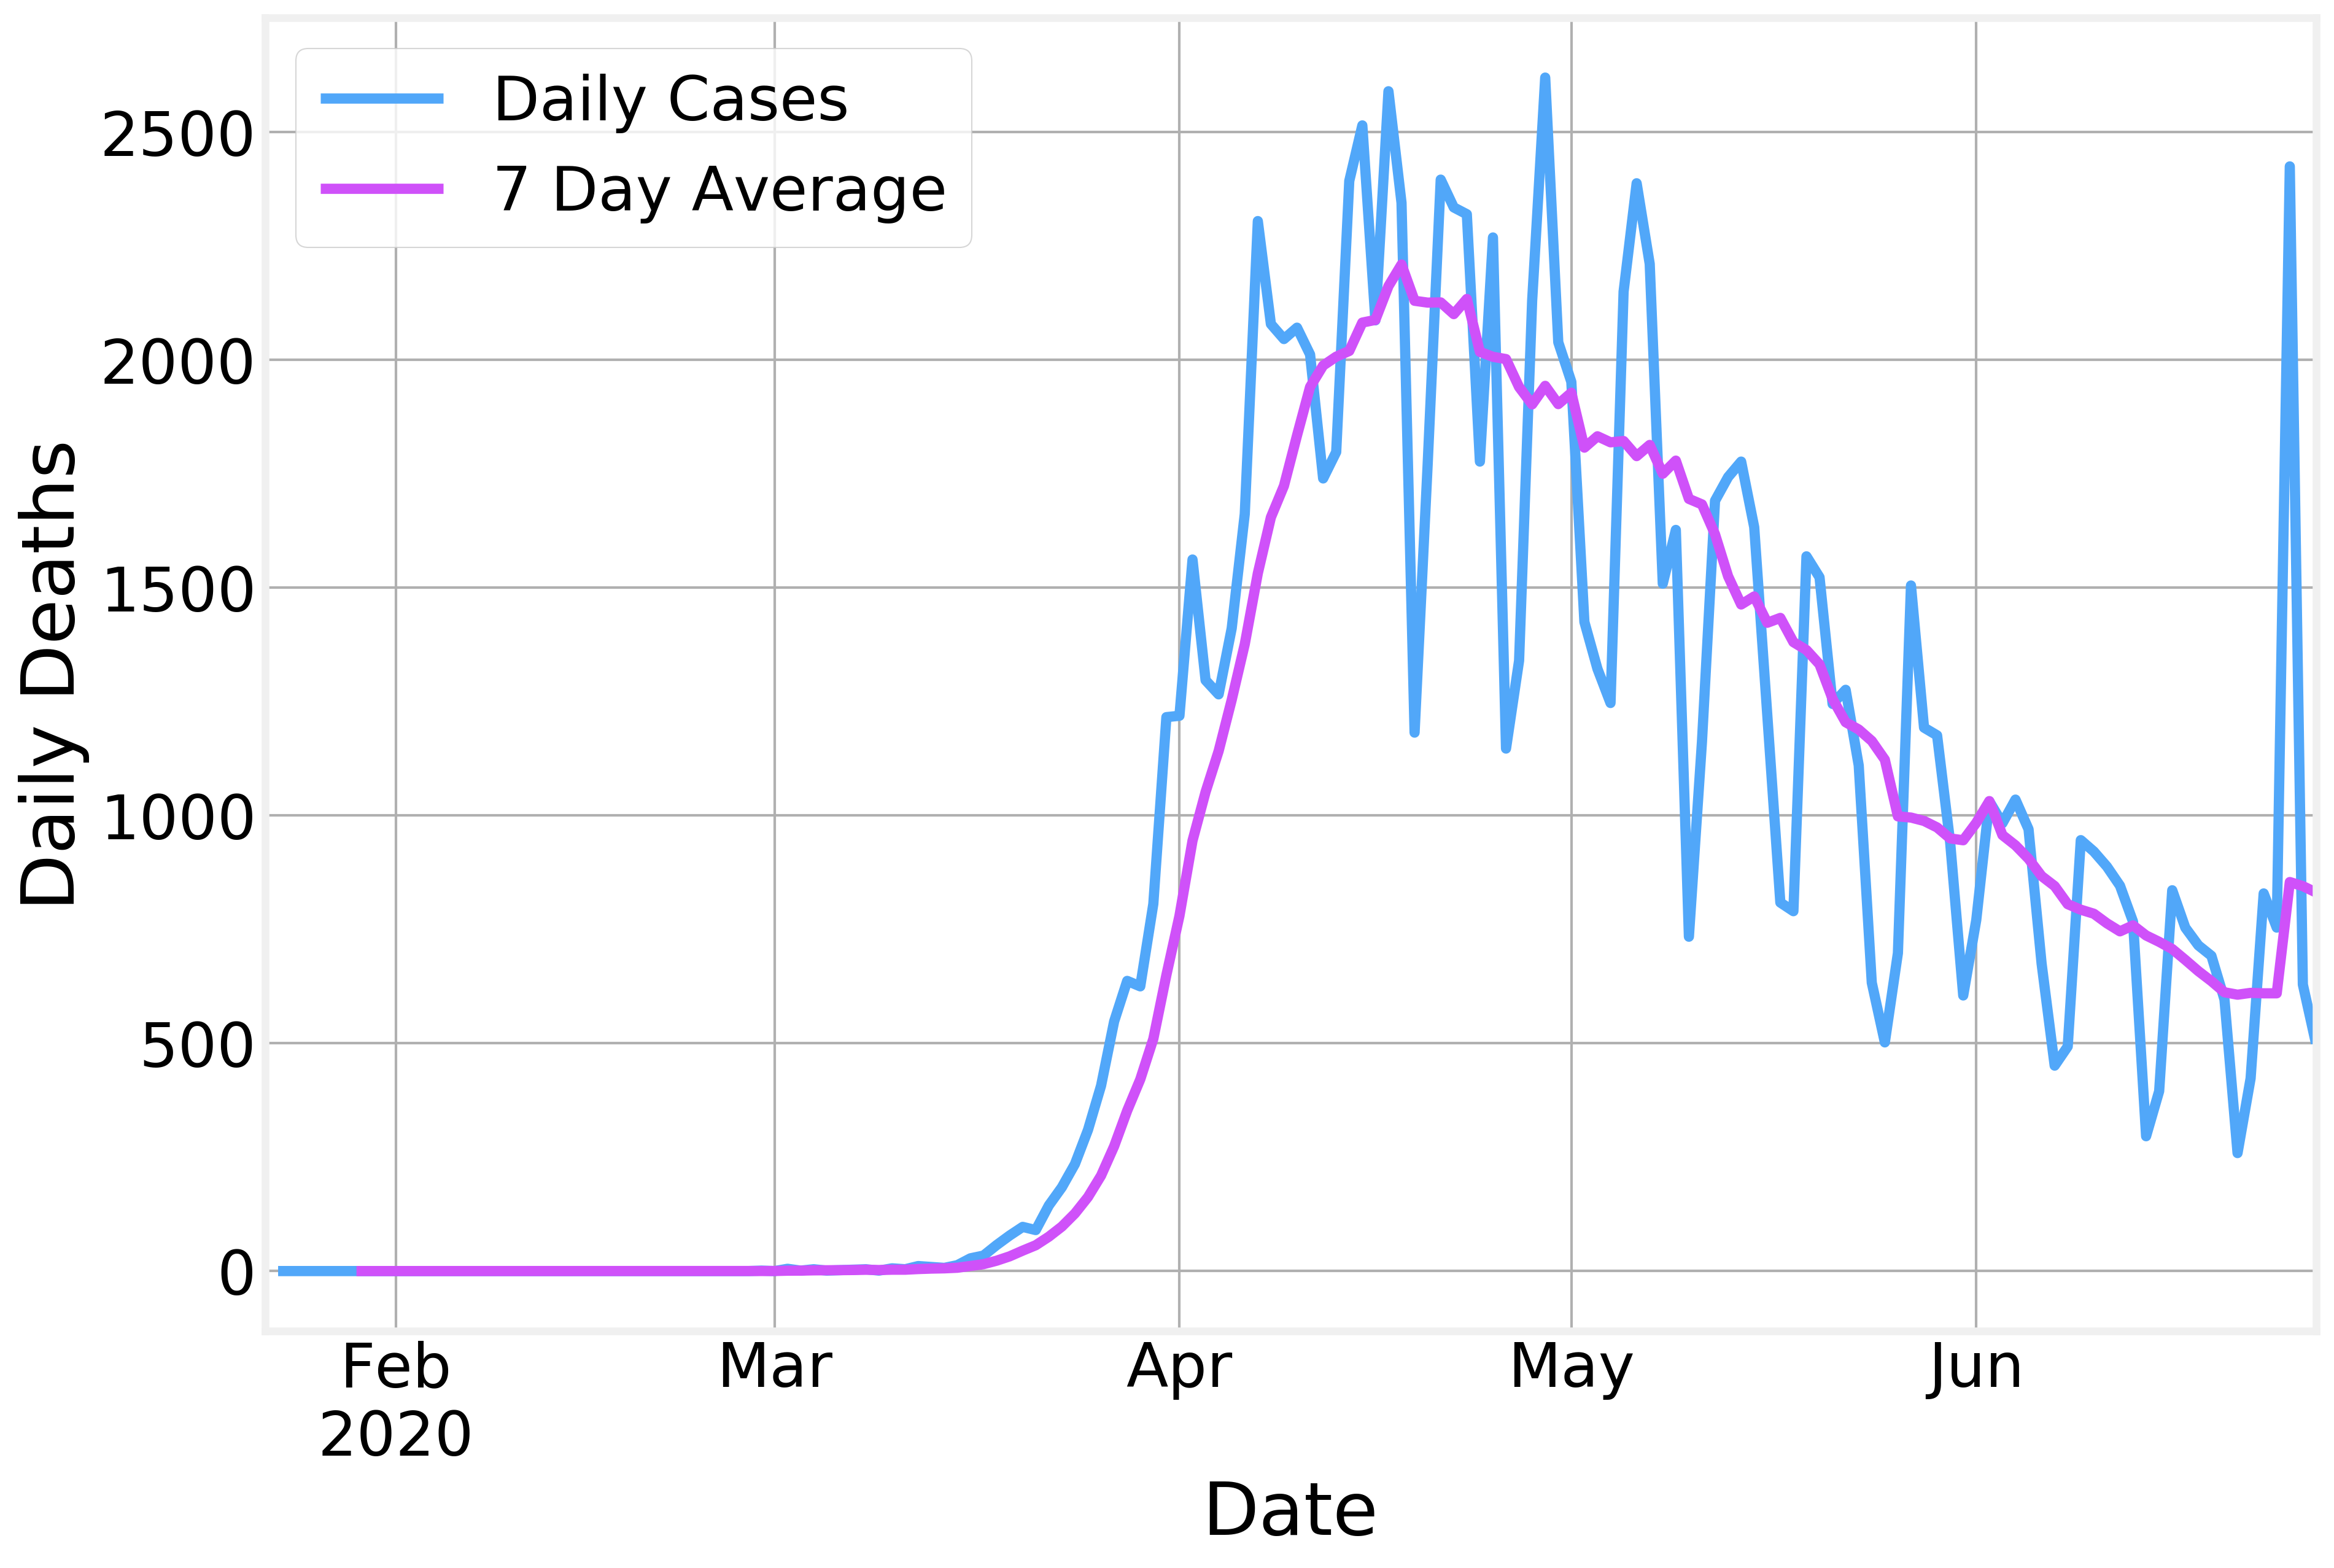

In [20]:
ax = deaths_timeline['US'].diff(1).plot(label='Daily Cases')
deaths_timeline['US'].diff(1).rolling(7).mean().plot(ax=ax, label='7 Day Average')
ax.set_xlabel('Date')
ax.set_ylabel('Daily Deaths')
ax.legend()

### Norway vs Sweden

We can also easily compare two similar countries to determine the effect of different approaches. The "classic" example is to compare Norway and Sweden as they are extremely similar countries geographically and culturally (Norway became independent from Sweden in 1915) but Sweden decided to no impose a official lock down, while Norway went on lockdown starting on the evening on March 12.

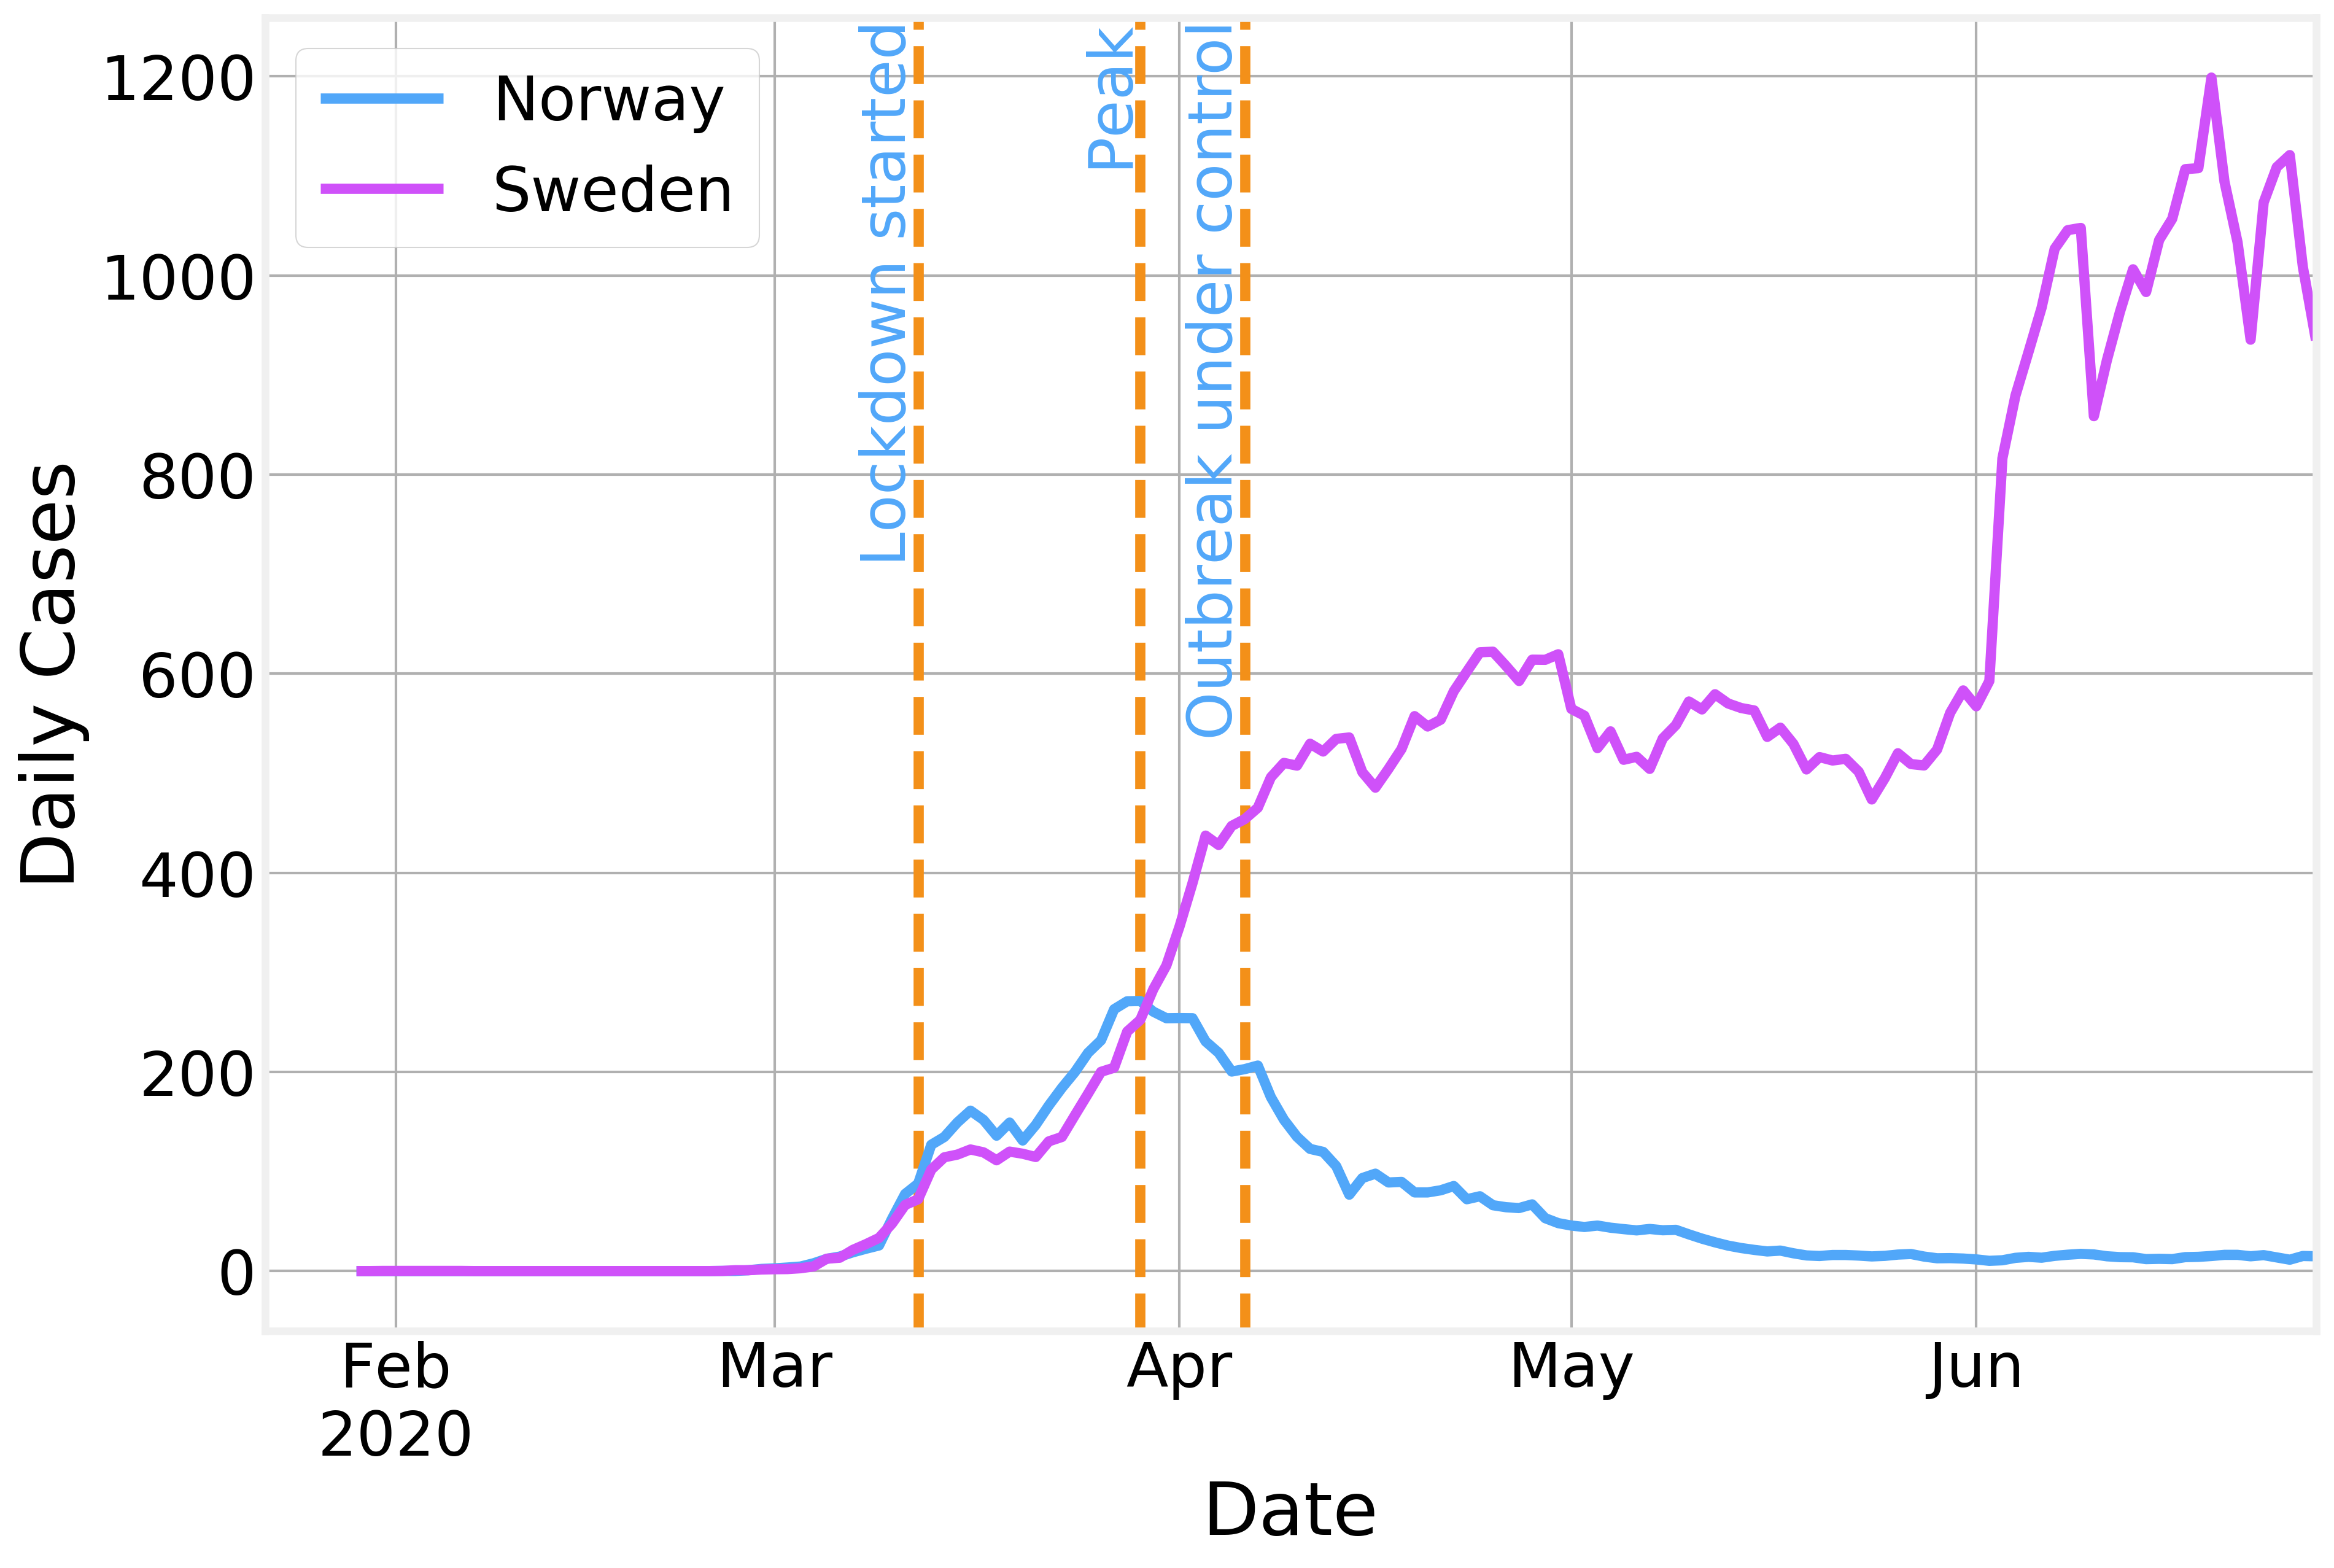

In [21]:
ax = confirmed_timeline[['Norway', 'Sweden']].diff(1).rolling(7).mean().plot()
ymin, ymax = ax.get_ylim()
ax.vlines(x=['2020/03/12', '2020/03/29', '2020/04/06'], ymin=ymin, ymax=ymax, linestyles='--', colors=colors[3])
ax.text(x='2020/03/12', y=ymax-2, s='Lockdown started', rotation=90, ha='right', va='top', color=colors[0])
ax.text(x='2020/03/29', y=ymax-2, s='Peak', rotation=90, ha='right', va='top', color=colors[0])
ax.text(x='2020/04/06', y=ymax-2, s='Outbreak under control', rotation=90, ha='right', va='top', color=colors[0])
ax.set_ylim(ymin, ymax)
ax.set_xlabel('Date')
ax.set_ylabel('Daily Cases')
ax.legend()

Similarly, for the number of deaths

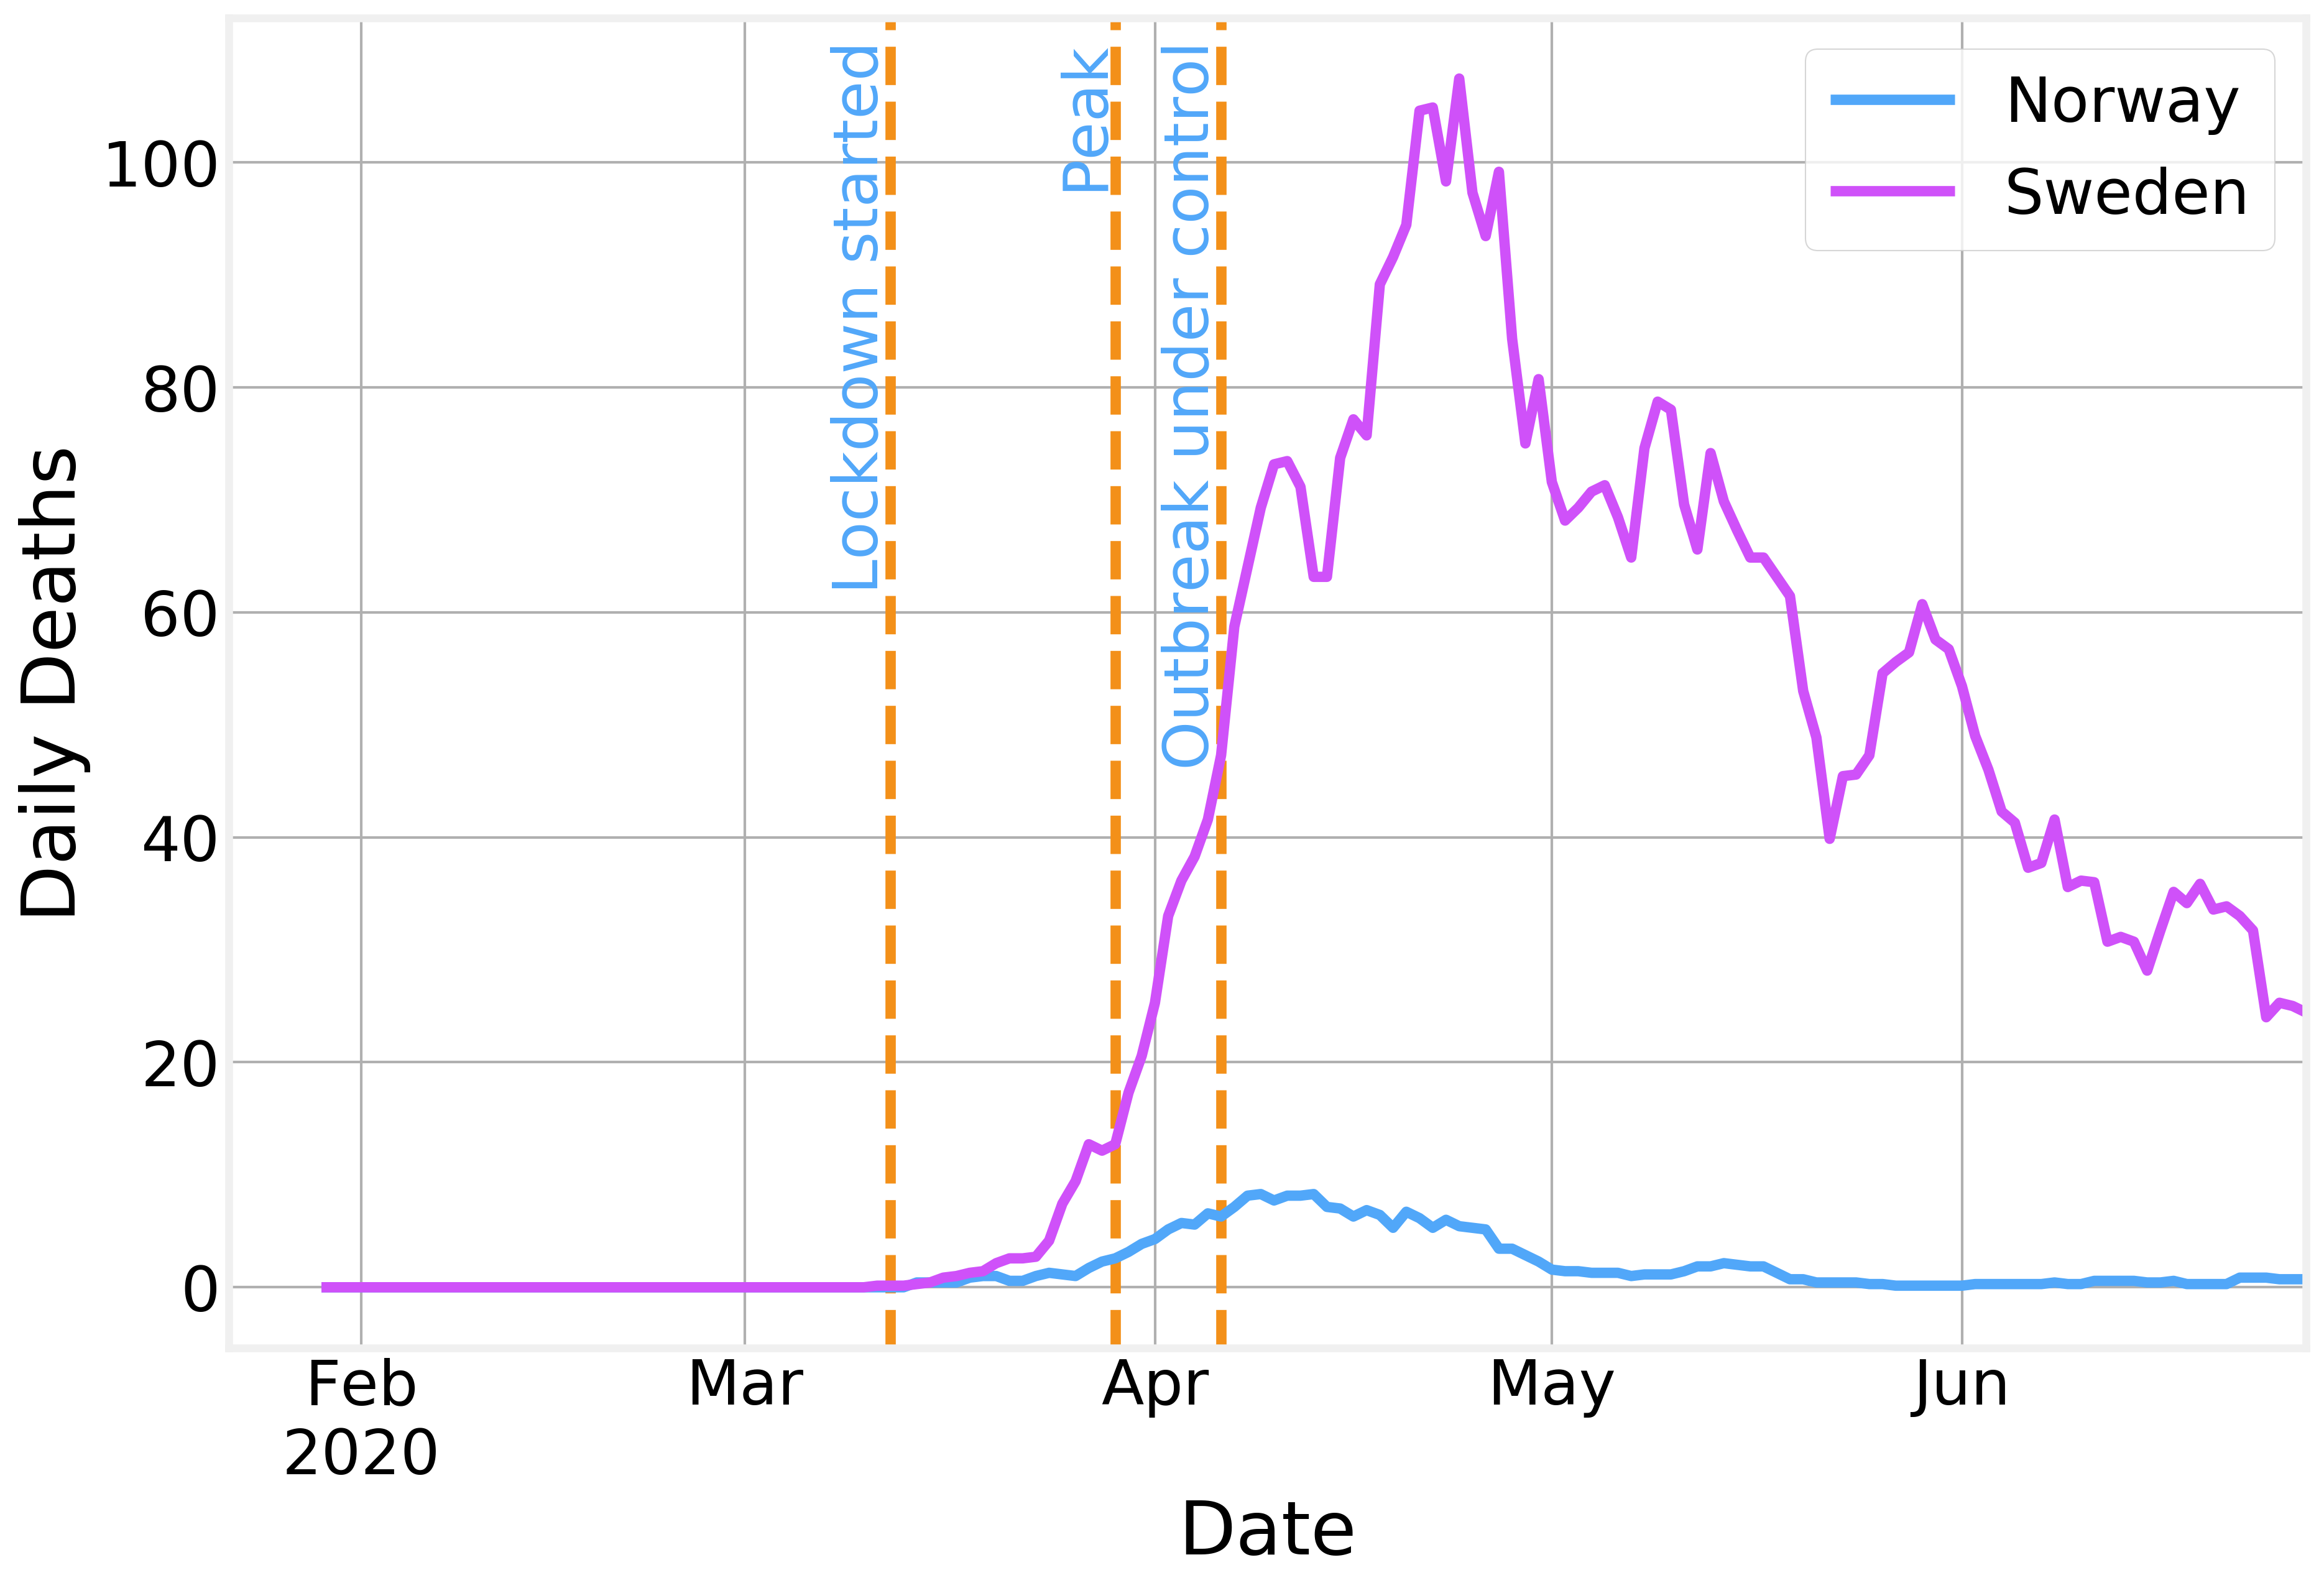

In [22]:
ax = deaths_timeline[['Norway', 'Sweden']].diff(1).rolling(7).mean().plot()
ymin, ymax = ax.get_ylim()
ax.vlines(x=['2020/03/12', '2020/03/29', '2020/04/06'], ymin=ymin, ymax=ymax, linestyles='--', colors=colors[3])
ax.text(x='2020/03/12', y=ymax-2, s='Lockdown started', rotation=90, ha='right', va='top', color=colors[0])
ax.text(x='2020/03/29', y=ymax-2, s='Peak', rotation=90, ha='right', va='top', color=colors[0])
ax.text(x='2020/04/06', y=ymax-2, s='Outbreak under control', rotation=90, ha='right', va='top', color=colors[0])
ax.set_ylim(ymin, ymax)
ax.set_xlabel('Date')
ax.set_ylabel('Daily Deaths')
ax.legend()

### Country timelines

Another plot that was popular was the shifted timelines. This is a relatively simple way of trying to forecast the course of the epidemic across multiple countries by directly comparing the shifted time series directly. This works relatively well at least at first.

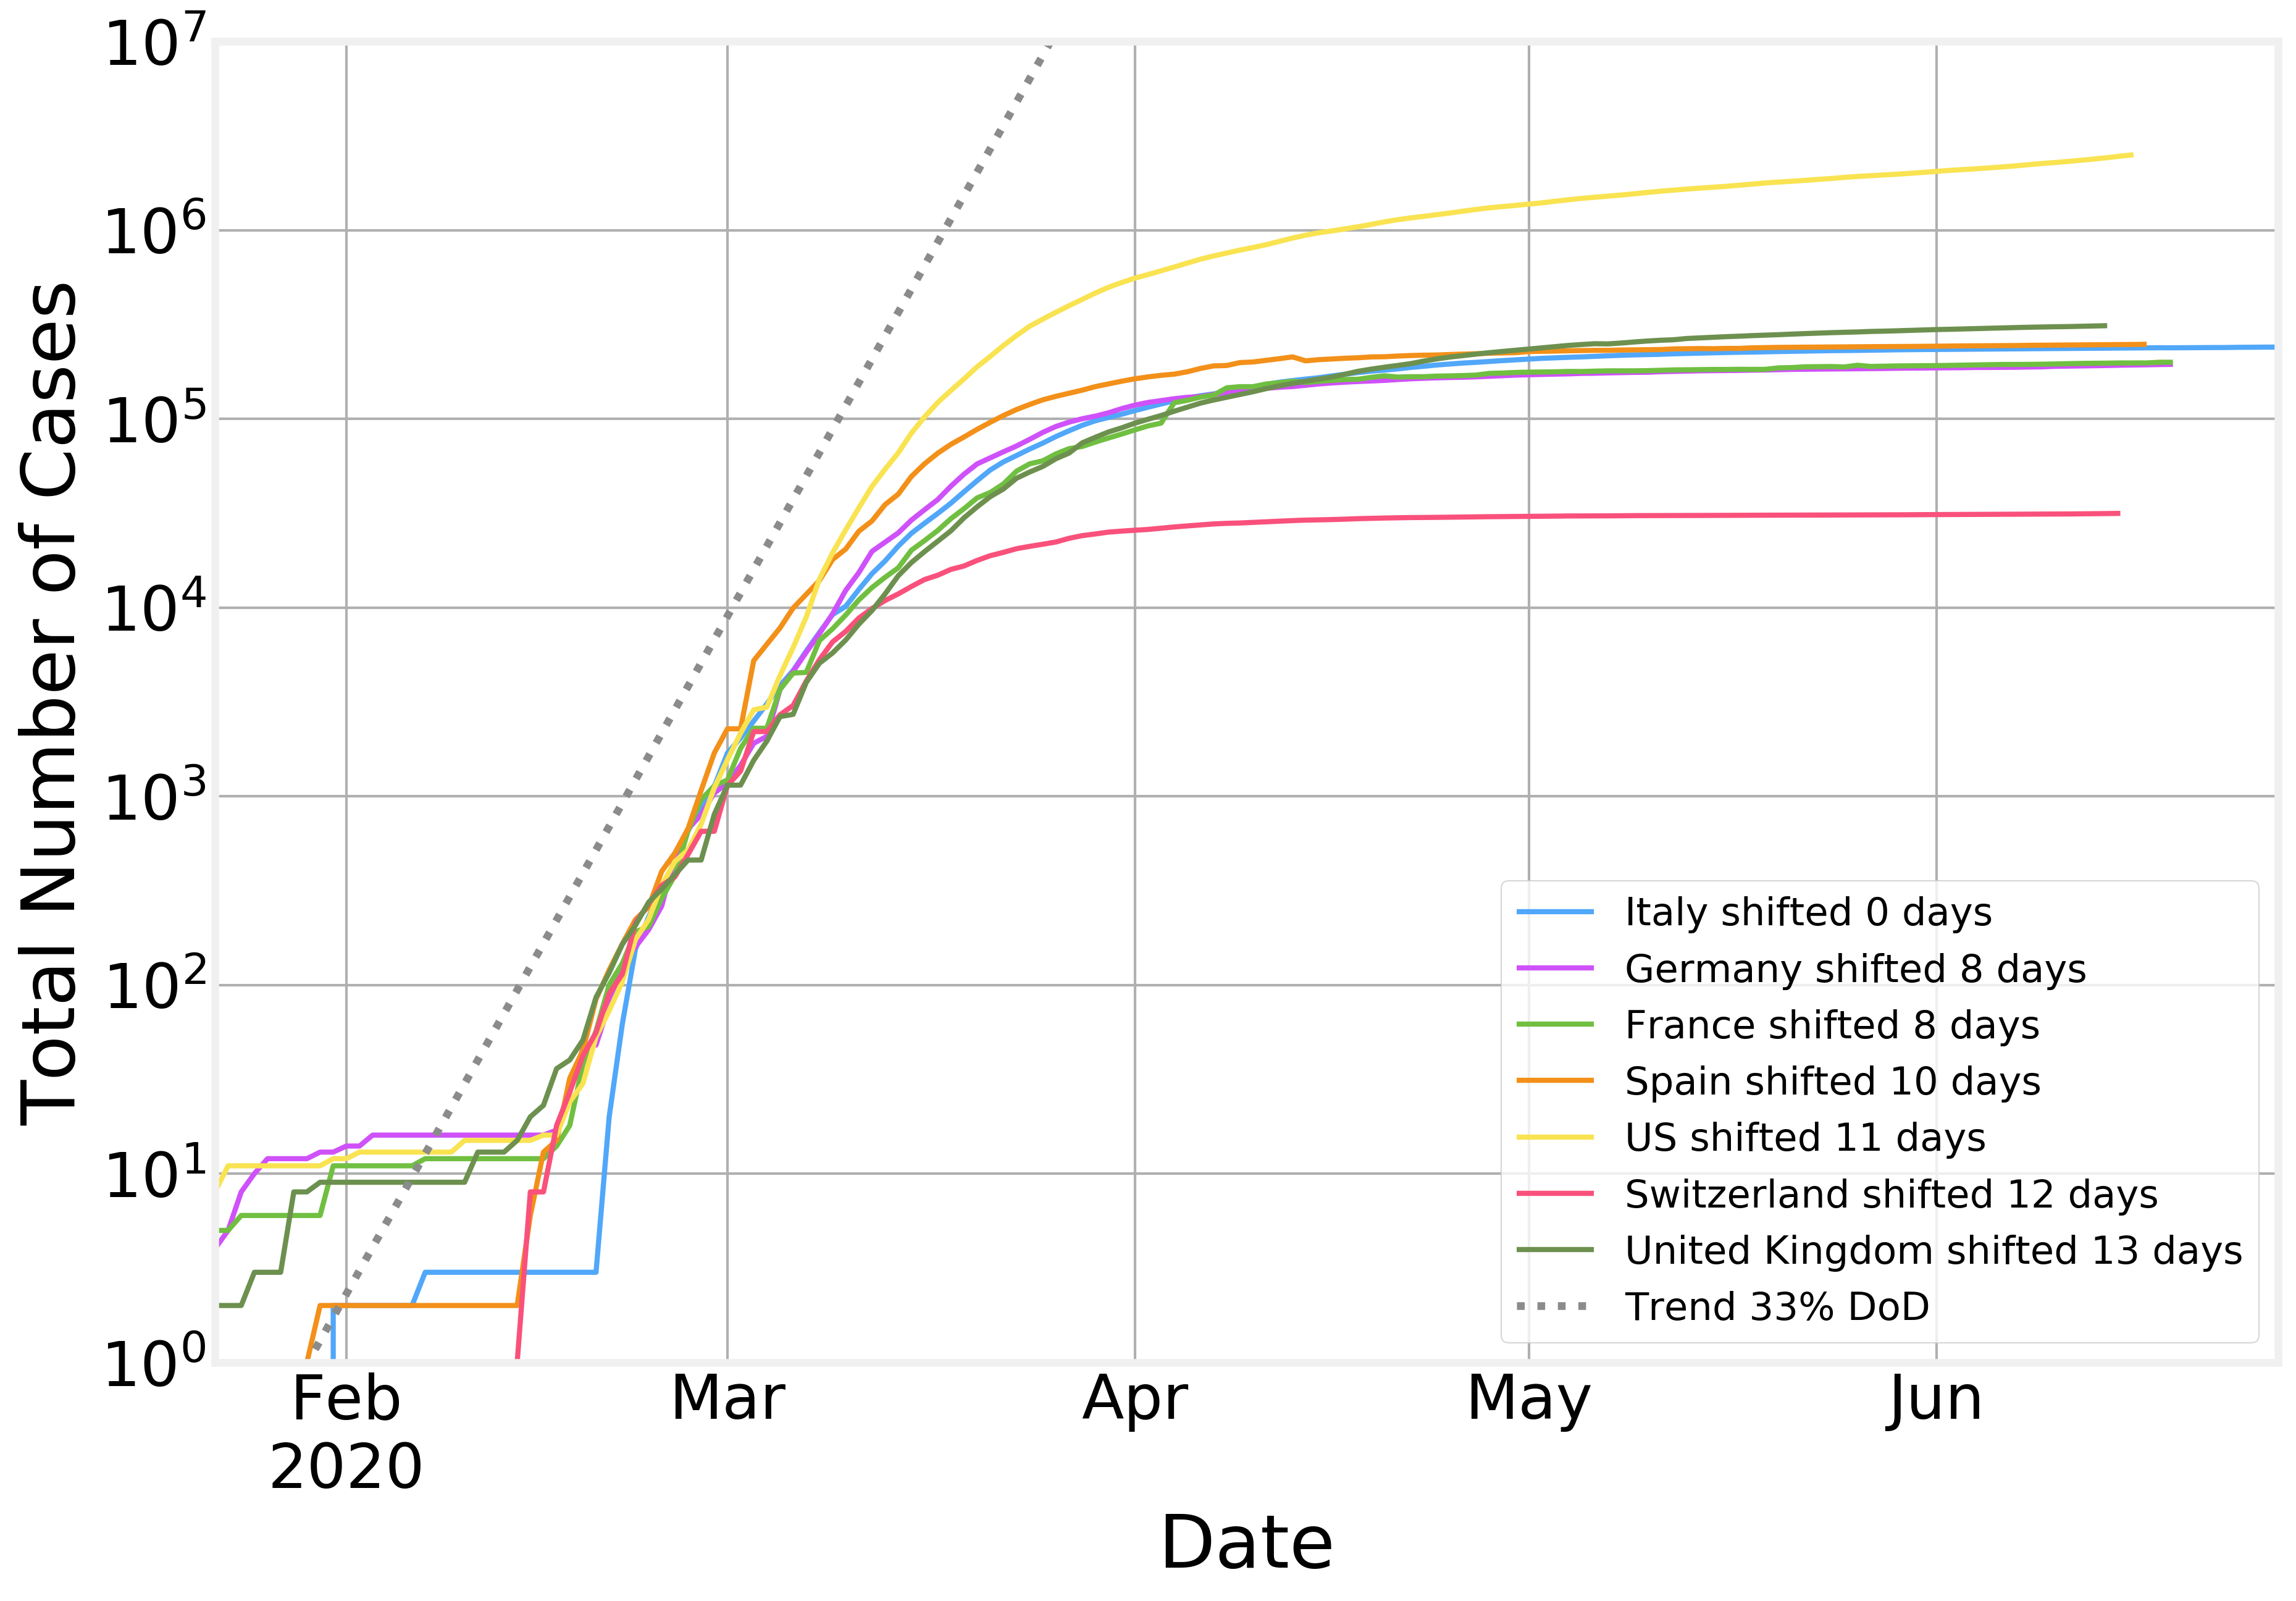

In [23]:
fig, ax = plt.subplots(1)

countries = ['Italy', 'Germany', 'France', 'Spain', 'US', 'Switzerland', 'United Kingdom']
shifts = np.array([0, 8, 8, 10, 11, 12, 13, 20])

for lag, country in enumerate(countries):
    confirmed_timeline[country].shift(-shifts[lag]).plot(ax=ax, lw=2, label='%s shifted %u days' % (country, shifts[lag]))

y = np.cumprod(1.33*np.ones(confirmed_timeline.shape[0]))

confirmed_timeline['Trend'] = y/10
confirmed_timeline['Trend'].plot(ax=ax, lw=3, linestyle=':', label='Trend 33% DoD')
    
ax.set_ylim(1, 1e7)
ax.set_xlabel('Date')
ax.set_ylabel('Total Number of Cases')
    
ax.legend(fontsize=15)
ax.set_yscale('log')

### Number of cases shift

A slightly more sophisticated way of doing it is to align the time series by the number of days since a specific number of cases. Here, as we are looking at the number of daily cases, it becomes a lot clearer that different countries behave differently. We identify 3 classes of countries:

- Those that are past their peak, in Green
- Those with an extended peak in Orange
- Those still increasing, in Red

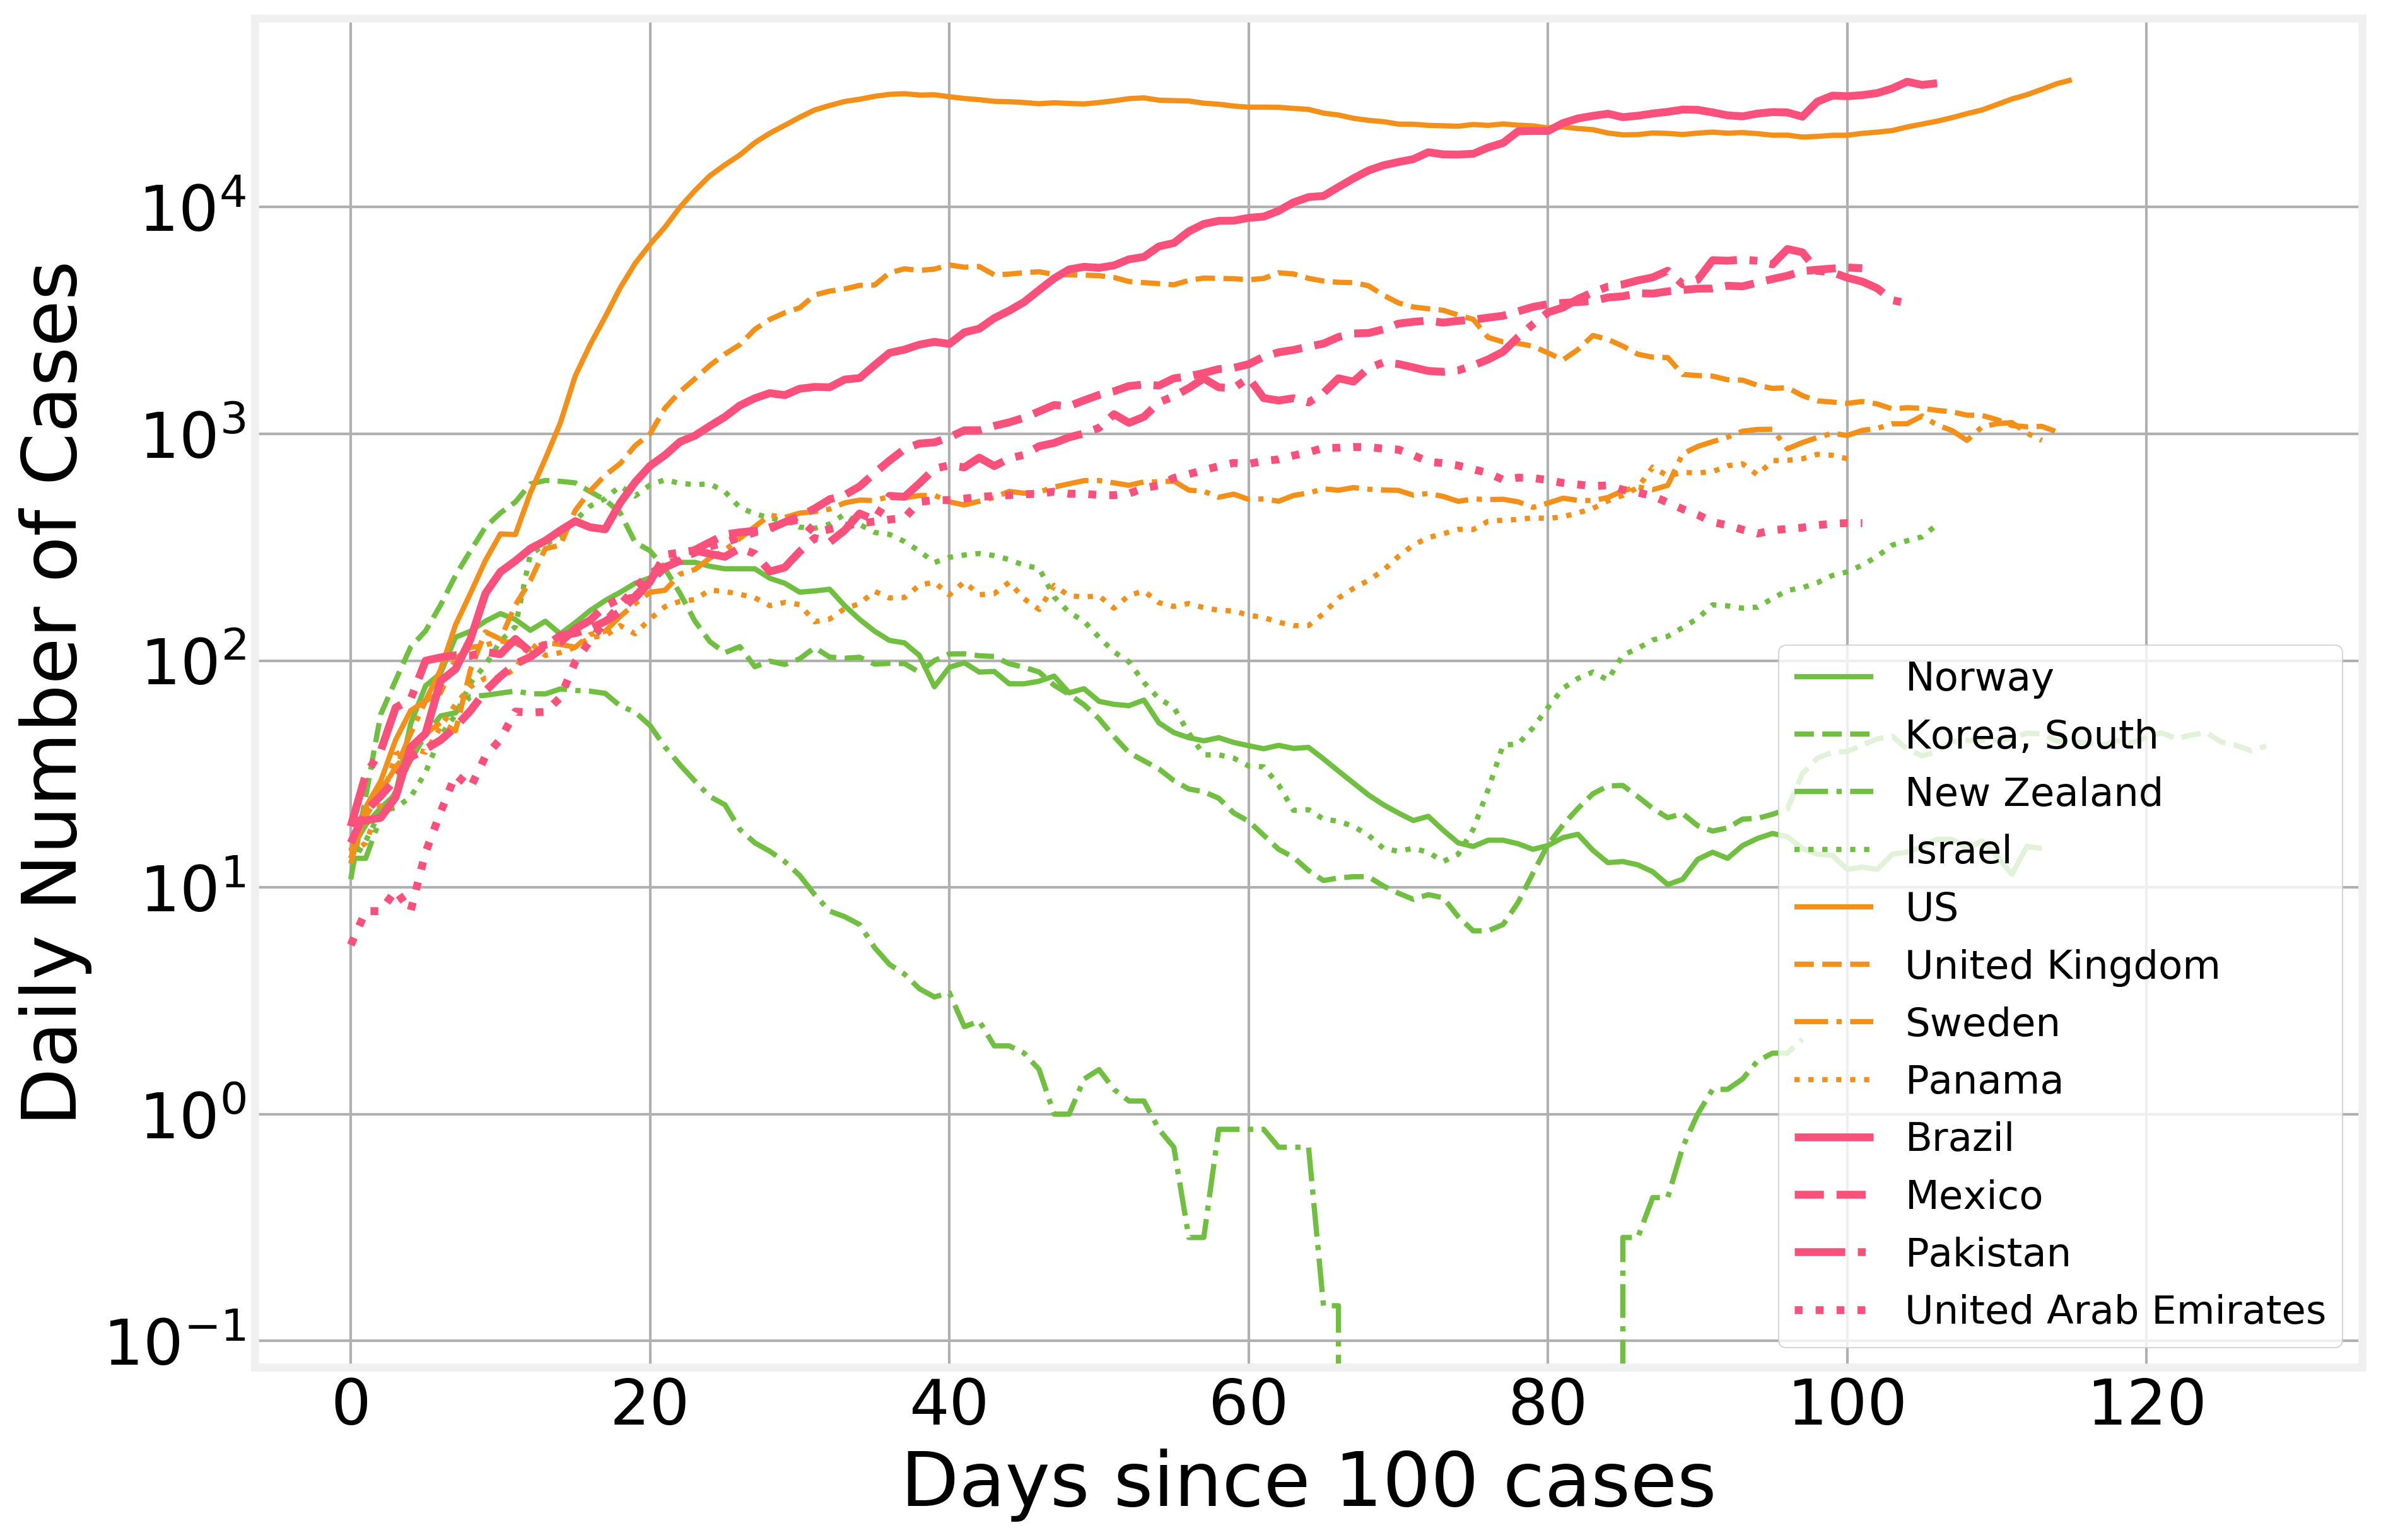

In [24]:
fig, ax = plt.subplots(1)

styles = ['-', '--', '-.', ':']

countries = ['Norway', 'Korea, South', 'New Zealand', 'Israel']
for i, country in enumerate(countries):
    timeline = confirmed_timeline[country].copy()
    timeline = timeline.diff(1).rolling(7).mean()[timeline > 100]
    ax.plot(np.arange(timeline.shape[0]), timeline.values, lw=2, 
            label=country, color=colors[2], linestyle=styles[i])


countries = ['US', 'United Kingdom', 'Sweden', 'Panama']
for i, country in enumerate(countries):
    timeline = confirmed_timeline[country].copy()
    timeline = timeline.diff(1).rolling(7).mean()[timeline > 100]
    ax.plot(np.arange(timeline.shape[0]), timeline.values, lw=2, 
            label=country, color=colors[3], linestyle=styles[i])

countries = ['Brazil', 'Mexico', 'Pakistan', 'United Arab Emirates']
for i, country in enumerate(countries):
    timeline = confirmed_timeline[country].copy()
    timeline = timeline.diff(1).rolling(7).mean()[timeline > 100]
    ax.plot(np.arange(timeline.shape[0]), timeline.values, lw=3, 
            label=country, color=colors[5], linestyle=styles[i])    
    
ax.set_xlabel('Days since 100 cases')
ax.set_ylabel('Daily Number of Cases')
    
ax.legend(fontsize=15)
ax.set_yscale('log')

### Peak times

The number of cases can vary significantly from country to country, making it harder to compare countries using time series as we've seen above. One way around it is to use a heatmap on the daily number of cases normalized by the peak value. For clarity, we start by subsetting just the countries with more than 10,000 cases

In [25]:
selected_countries = confirmed_timeline.T[confirmed_timeline.max(axis=0)>10000].index

And normalize it by the peak value

In [26]:
peaks = confirmed_timeline[selected_countries].diff(1).rolling(7).mean().T.apply(lambda x:x/x.max(), axis=1)

And sort the countries by the peak date

In [27]:
sorted_countries = peaks.T.idxmax().sort_values().iloc[:-1].index

In total we now have 52 countries

In [28]:
len(sorted_countries)

66

And finally, we make the heat map with all the countries in order

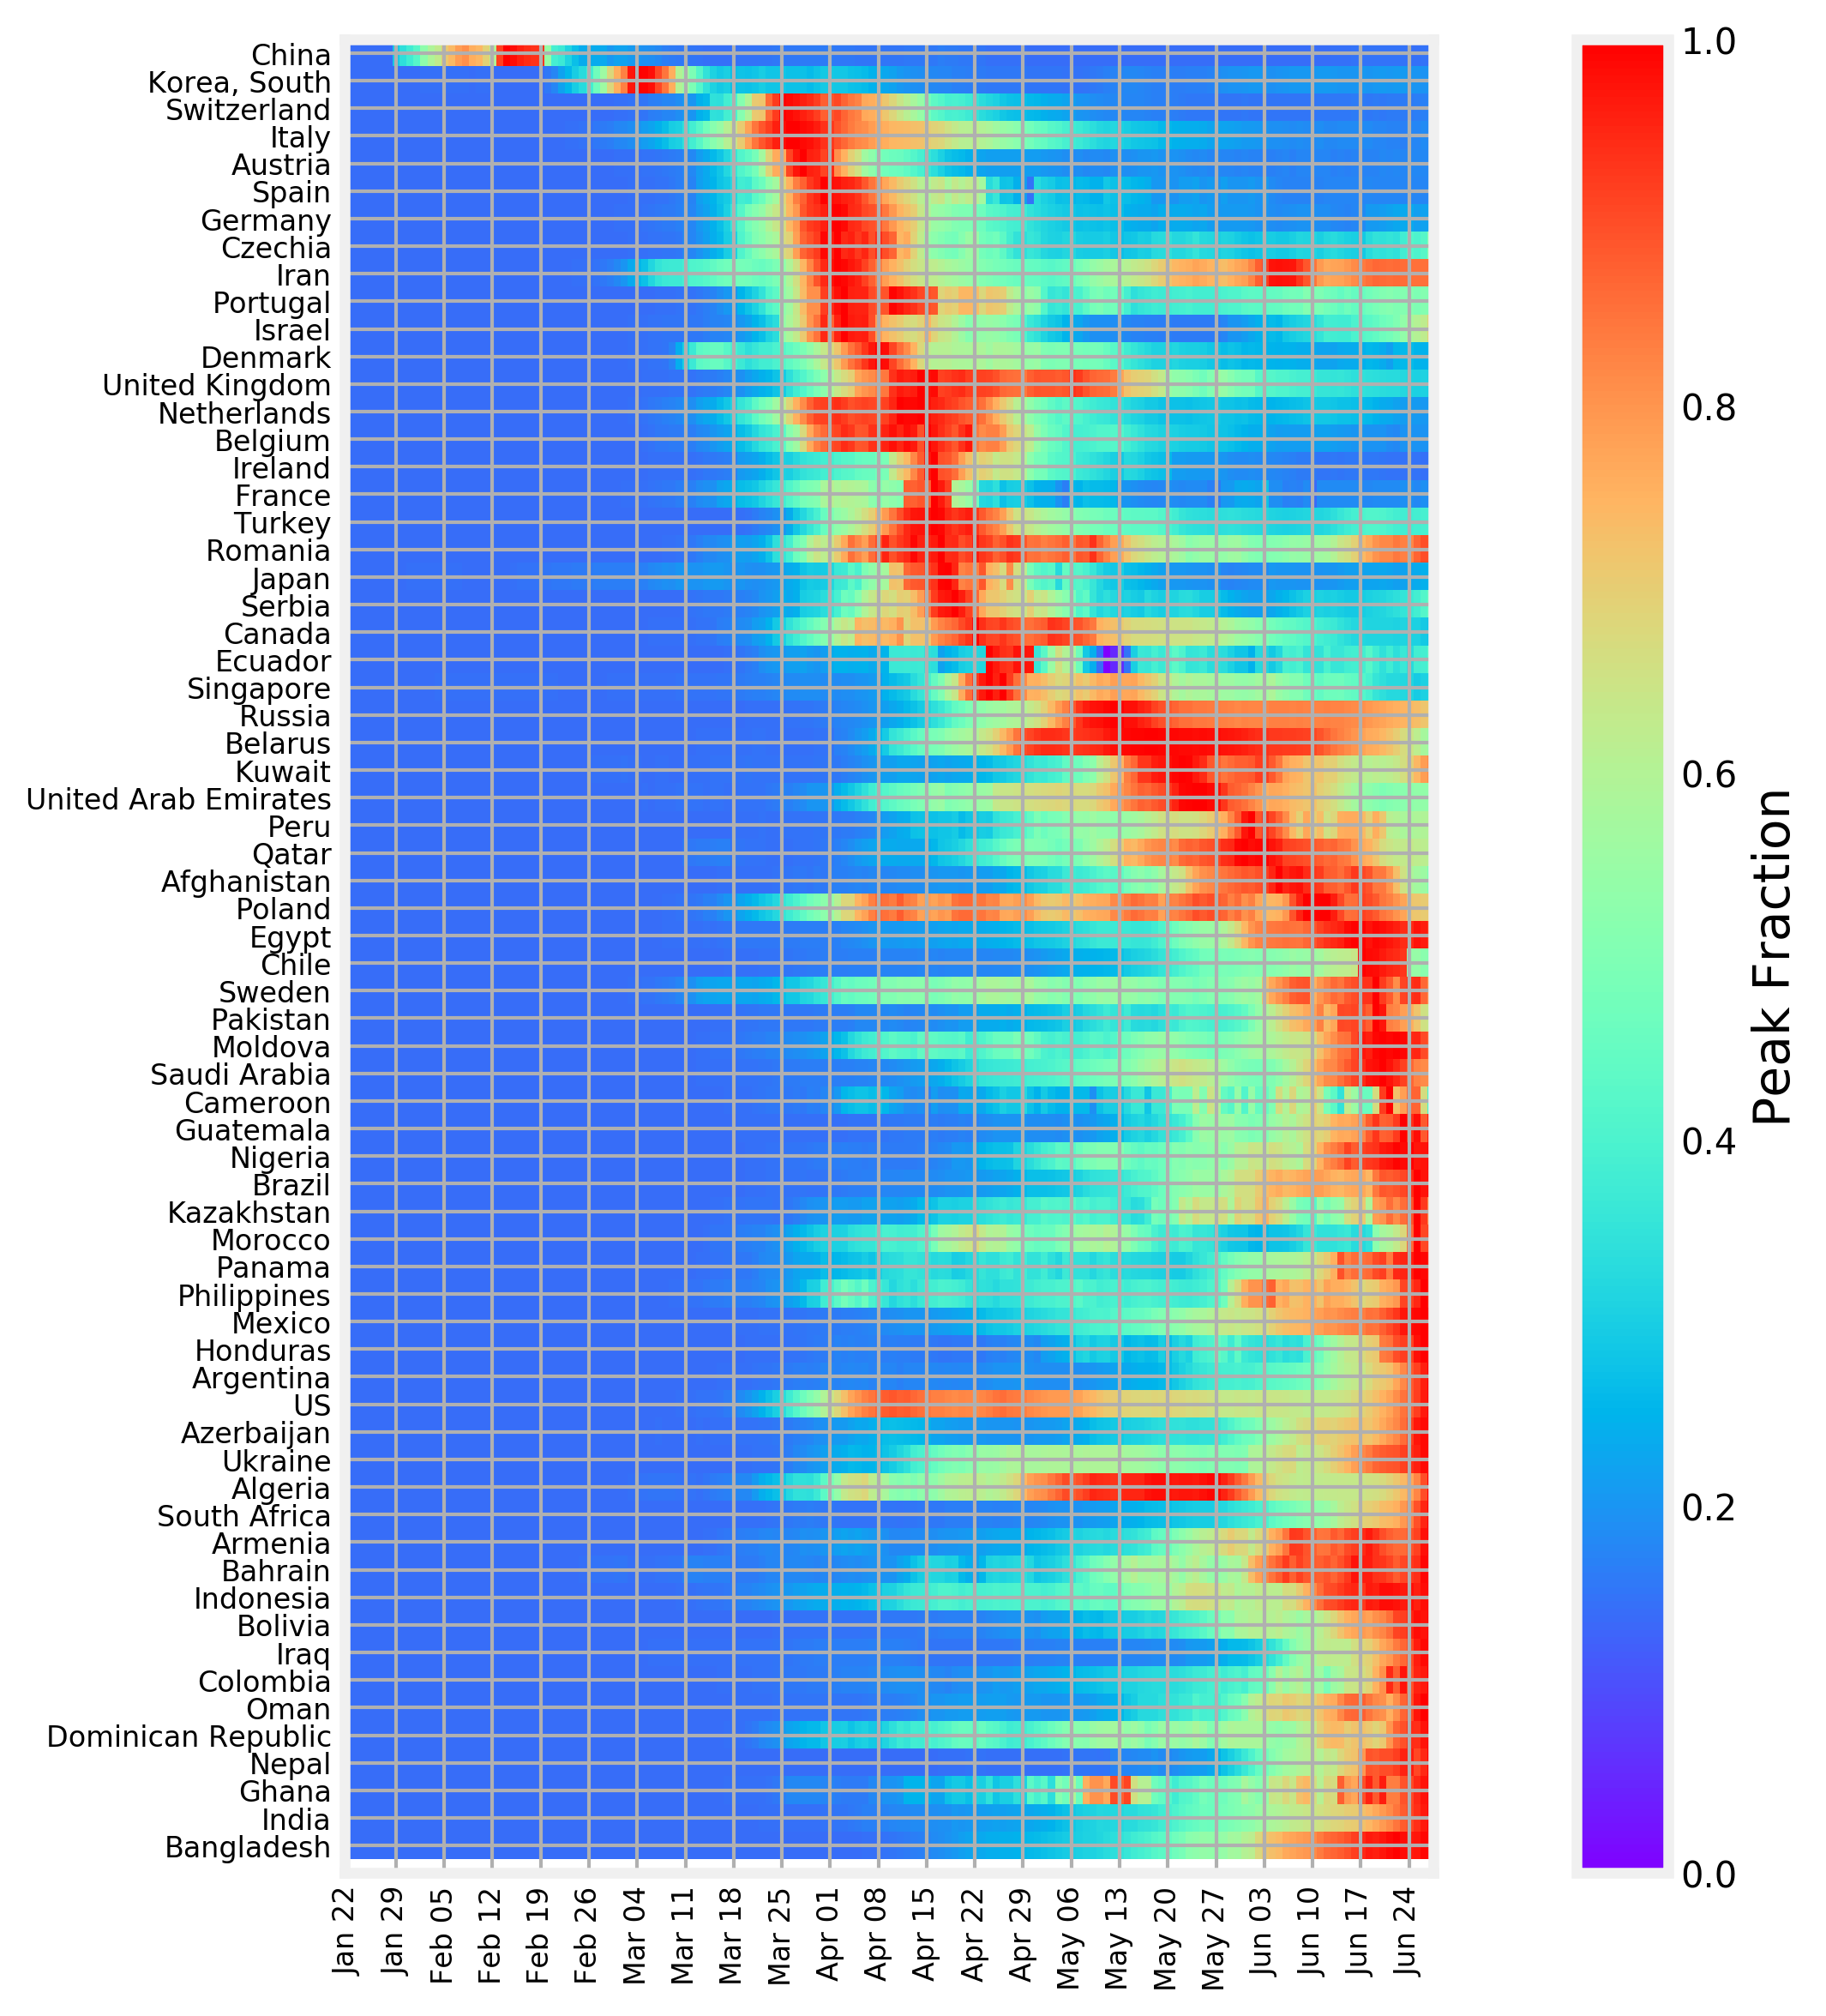

In [29]:
fig, ax = plt.subplots(1)

norm = mpl.colors.Normalize(vmin=0,vmax=1)
sm = plt.cm.ScalarMappable(cmap=plt.cm.rainbow, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax)
cbar.ax.tick_params(labelsize=10)
cbar.set_label('Peak Fraction', fontsize=14)

ax.imshow(peaks.loc[sorted_countries].fillna(0).values, cmap=plt.cm.rainbow)
ax.set_xticks(np.arange(0, peaks.shape[1], 7))
ax.set_xticklabels([day.strftime("%b %d") for day in peaks.columns[::7]], fontsize=8, rotation=90)
ax.set_yticks(np.arange(0, peaks.shape[0]))
ax.set_yticklabels(sorted_countries, fontsize=8)
ax.set_aspect(4)
fig.patch.set_facecolor('#FFFFFF')

## US Data



Now we take a detailed look at the situation within the US. The JHU github also has data for the US by state and county (admin2) level.

In [30]:
confirmed_US = pd.read_csv(url + 'time_series_covid19_confirmed_US.csv')
deaths_US = pd.read_csv(url + 'time_series_covid19_deaths_US.csv')

As in the case of the country level data, there are several other columns that we don't need

In [31]:
confirmed_US.head()

UID iso2 iso3  code3  FIPS Admin2            Province_State Country_Region  \
0   16   AS  ASM     16  60.0    NaN            American Samoa             US   
1  316   GU  GUM    316  66.0    NaN                      Guam             US   
2  580   MP  MNP    580  69.0    NaN  Northern Mariana Islands             US   
3  630   PR  PRI    630  72.0    NaN               Puerto Rico             US   
4  850   VI  VIR    850  78.0    NaN            Virgin Islands             US   

       Lat     Long_  ... 6/18/20  6/19/20  6/20/20  6/21/20  6/22/20  \
0 -14.2710 -170.1320  ...       0        0        0        0        0   
1  13.4443  144.7937  ...     192      200      222      222      222   
2  15.0979  145.6739  ...      30       30       30       30       30   
3  18.2208  -66.5901  ...    6111     6195     6463     6525     6564   
4  18.3358  -64.8963  ...      73       73       73       76       76   

   6/23/20  6/24/20  6/25/20  6/26/20  6/27/20  
0        0        0        0        0        0  
1      225      226      231      247      247  
2       30       30       30       30       30  
3     6685     6820     6877     6922     7066  
4       76       76       80       81       81  

[5 rows x 169 columns]

We remove the extraneous columns

In [32]:
del_columns = [
 'UID',
 'iso2',
 'iso3',
 'code3',
 'FIPS',
 'Country_Region',
 'Lat',
 'Long_',
 'Combined_Key',
]

And aggregate at the state level.

In [33]:
confirmed_US.drop(columns=del_columns, inplace=True)

NY = confirmed_US[confirmed_US['Province_State'] == 'New York'].copy()
NY.drop(columns='Province_State', inplace=True)

confirmed_US.drop(columns='Admin2', inplace=True)

deaths_US.drop(columns=del_columns, inplace=True)
deaths_US.drop(columns='Population', inplace=True)

confirmed_US = confirmed_US.groupby('Province_State').sum().T
deaths_US = deaths_US.groupby('Province_State').sum().T

confirmed_US.index = pd.to_datetime(confirmed_US.index)
deaths_US.index = pd.to_datetime(deaths_US.index)

For ease of reference, we also extract the detailed New York county level data

In [34]:
NY = NY.set_index('Admin2').T
NY.index = pd.to_datetime(NY.index)

### State Comparison

As before, we can easily extract the totals for each state

Text(0, 0.5, 'Total cases')

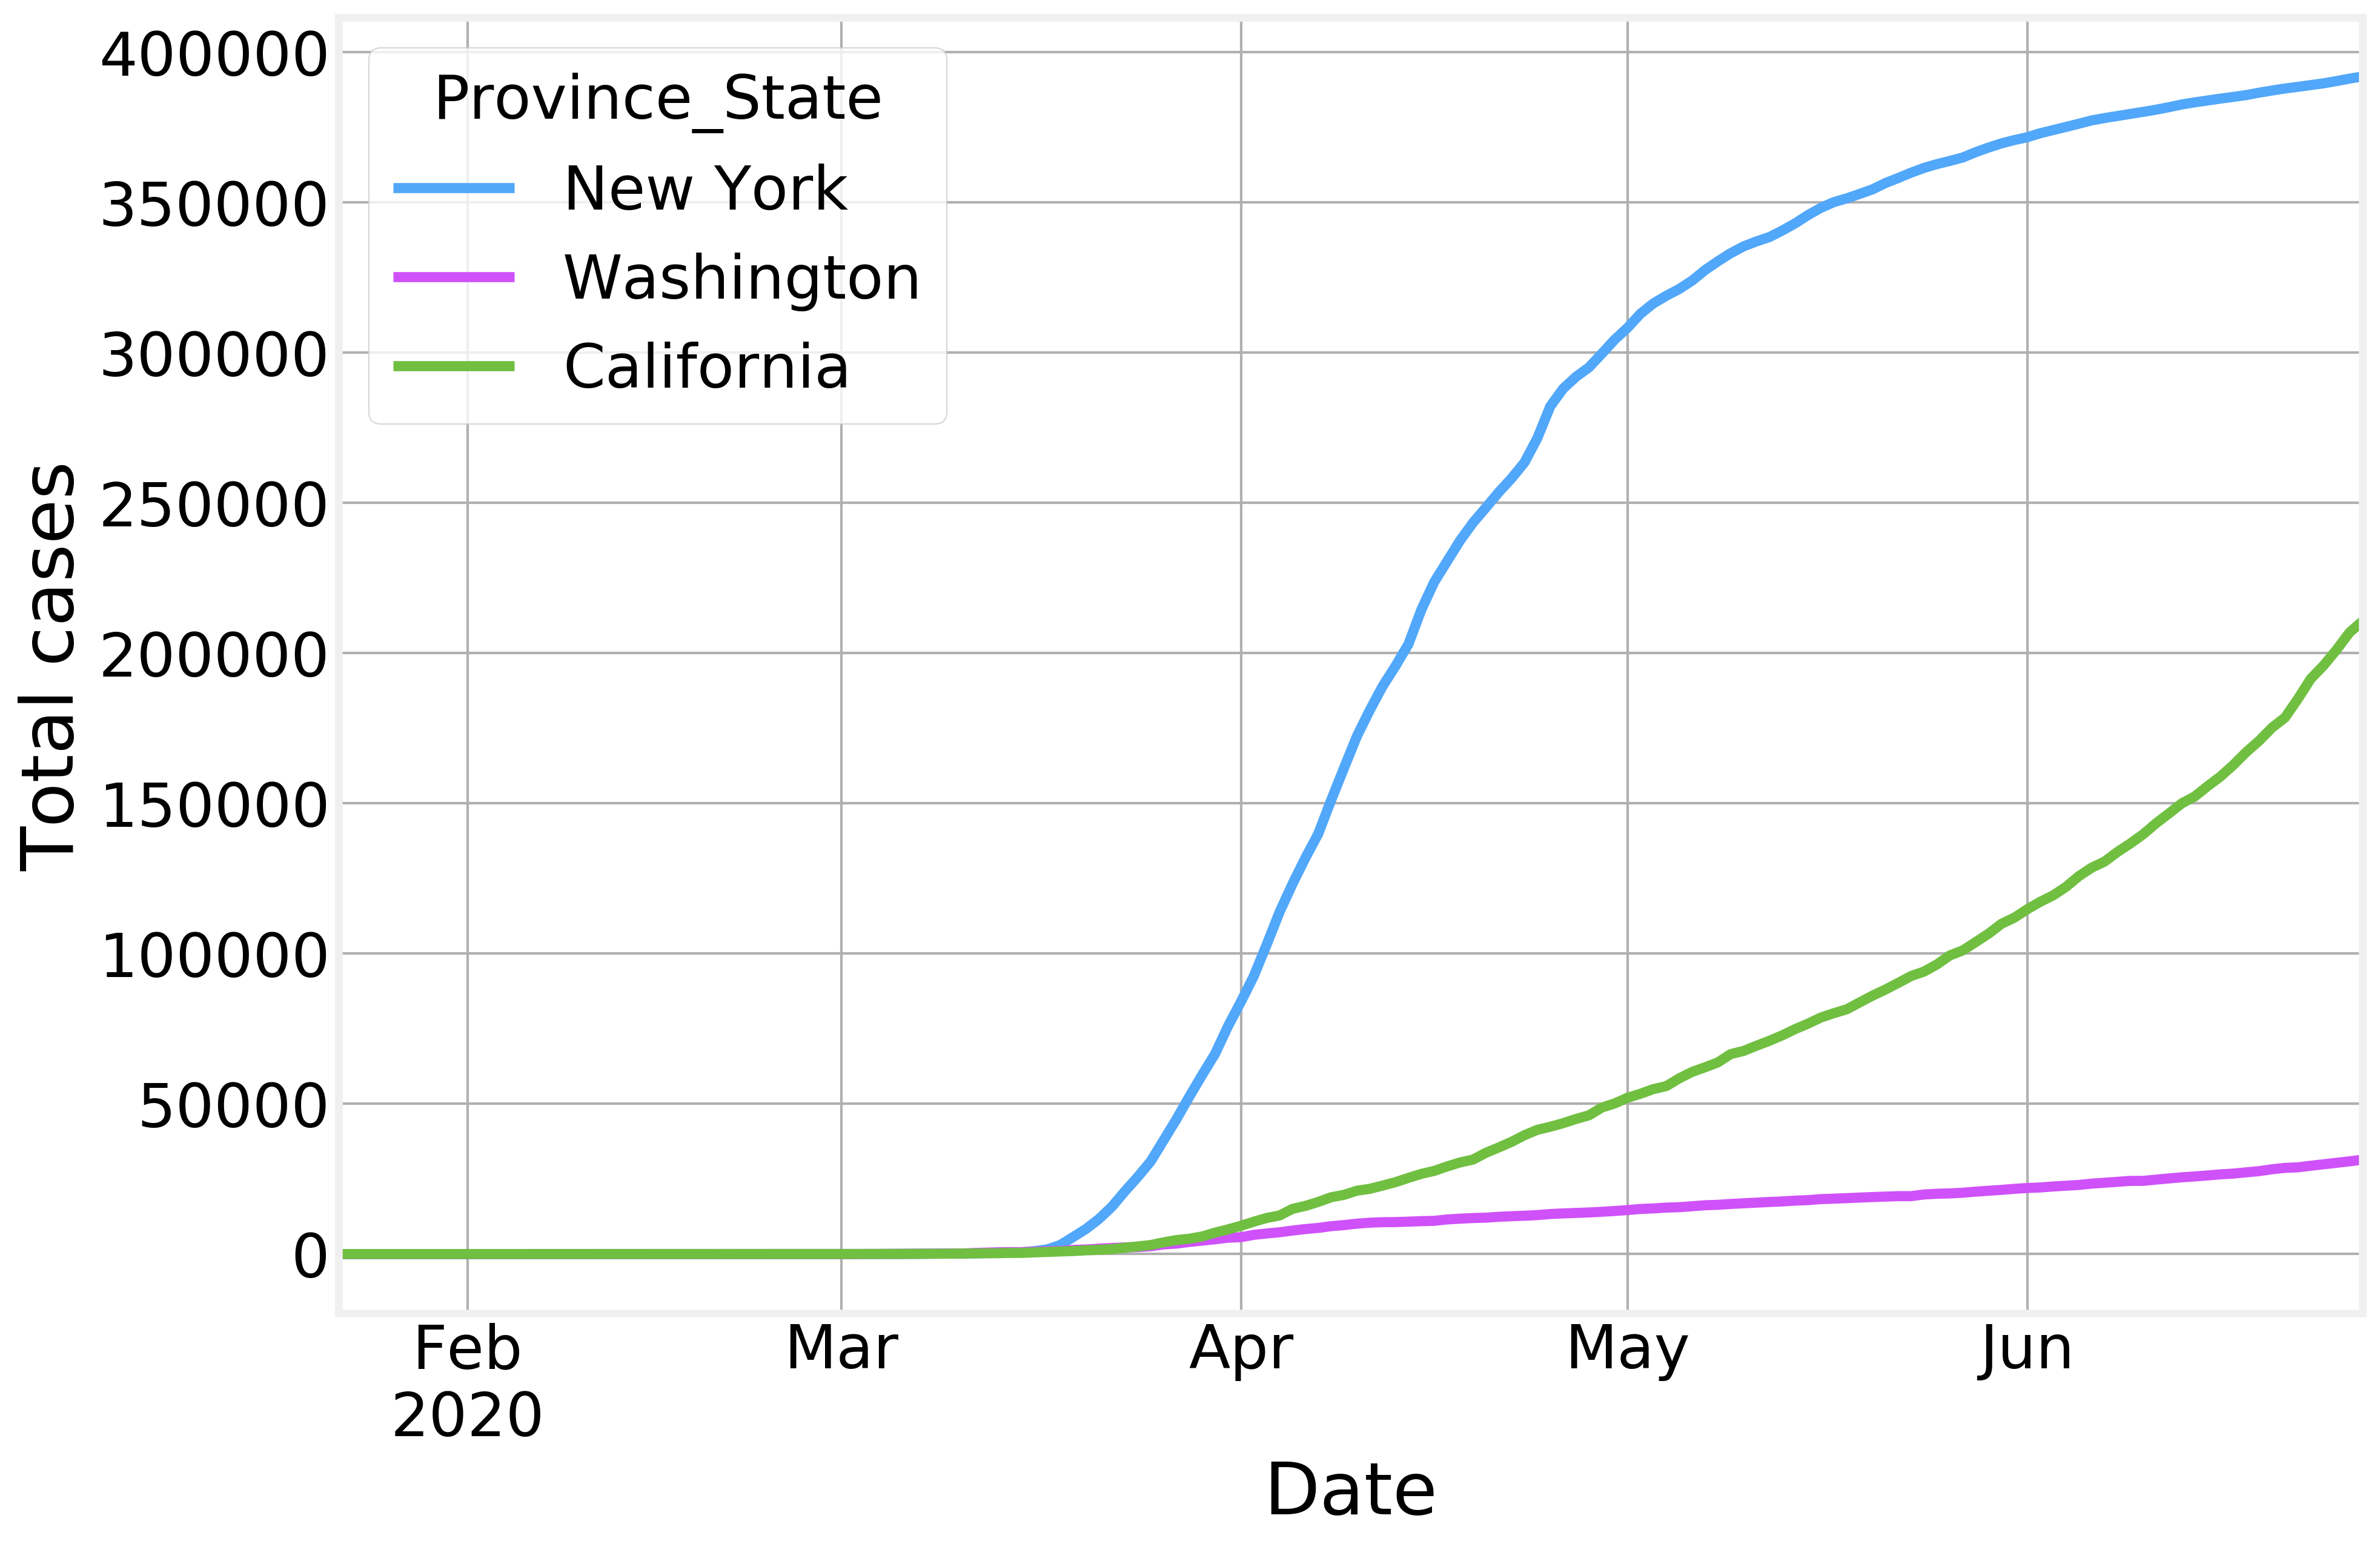

In [35]:
ax = confirmed_US[['New York', 'Washington', 'California']].plot()
ax.set_xlabel('Date')
ax.set_ylabel('Total cases')

And convert back to daily values:

In [36]:
daily_US = confirmed_US.diff(1).rolling(7).mean()

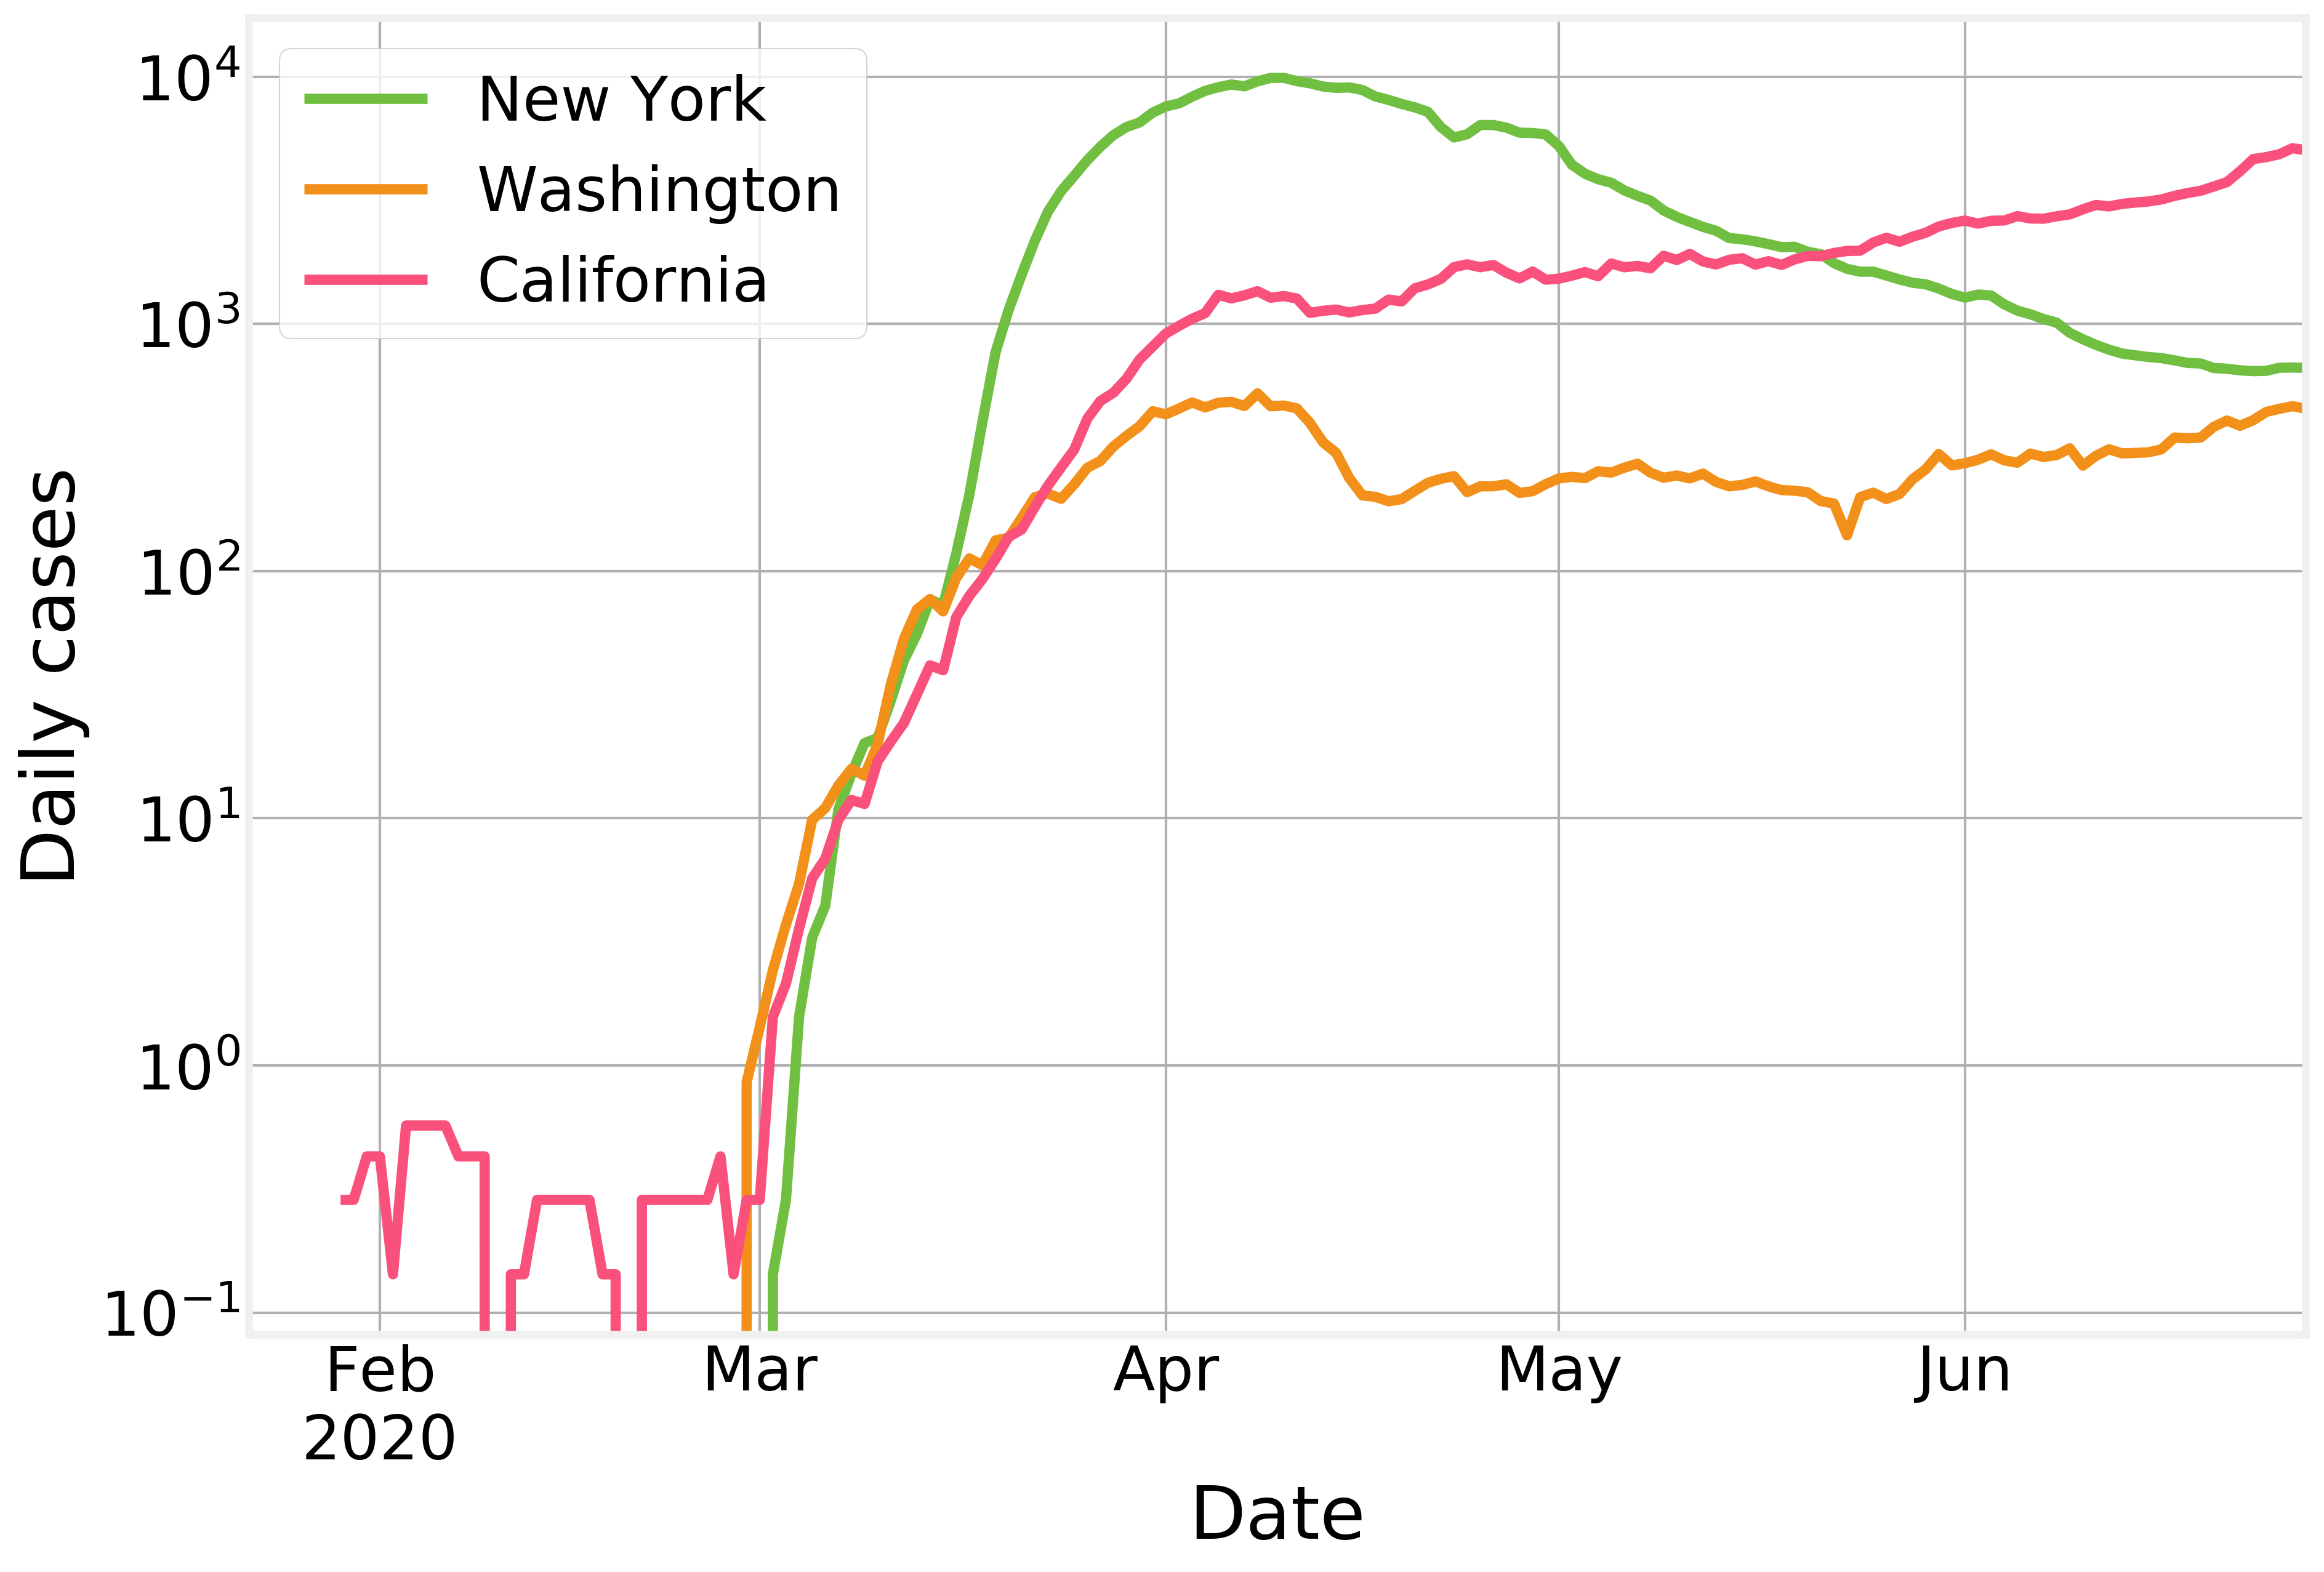

In [37]:
ax = daily_US['New York'].plot(color=colors[2])
daily_US['Washington'].plot(color=colors[3], ax=ax)
daily_US['California'].plot(color=colors[5], ax=ax)
ax.legend()
ax.set_xlabel('Date')
ax.set_ylabel('Daily cases')
ax.set_yscale('log')

### Country Overview

A simply way of getting a quick overview of the situation in all the states is to include some degree of geographical information to plot the time series of all the states side by side. We opt to use a block map where each state is represented by an equal size square block where we can plot the time series.

We load the coordinates of each state from a csv file

In [38]:
states = pd.read_csv('data/states.csv', index_col=0)

And create a convenient dictionary to convert from state abbreviations to full state names

In [39]:
state_dict = dict(states.reset_index()[['index', 'name']].values)

And now we plot the time series for each state, normalized by the peak value, within each block. Further, we color the block based on the current value of the number of cases:

- Green, below 25% of the peak value
- Orange, between 25-75% of the peak value
- Red, above 75% of the peak value

as an indication of how well each state is doing.

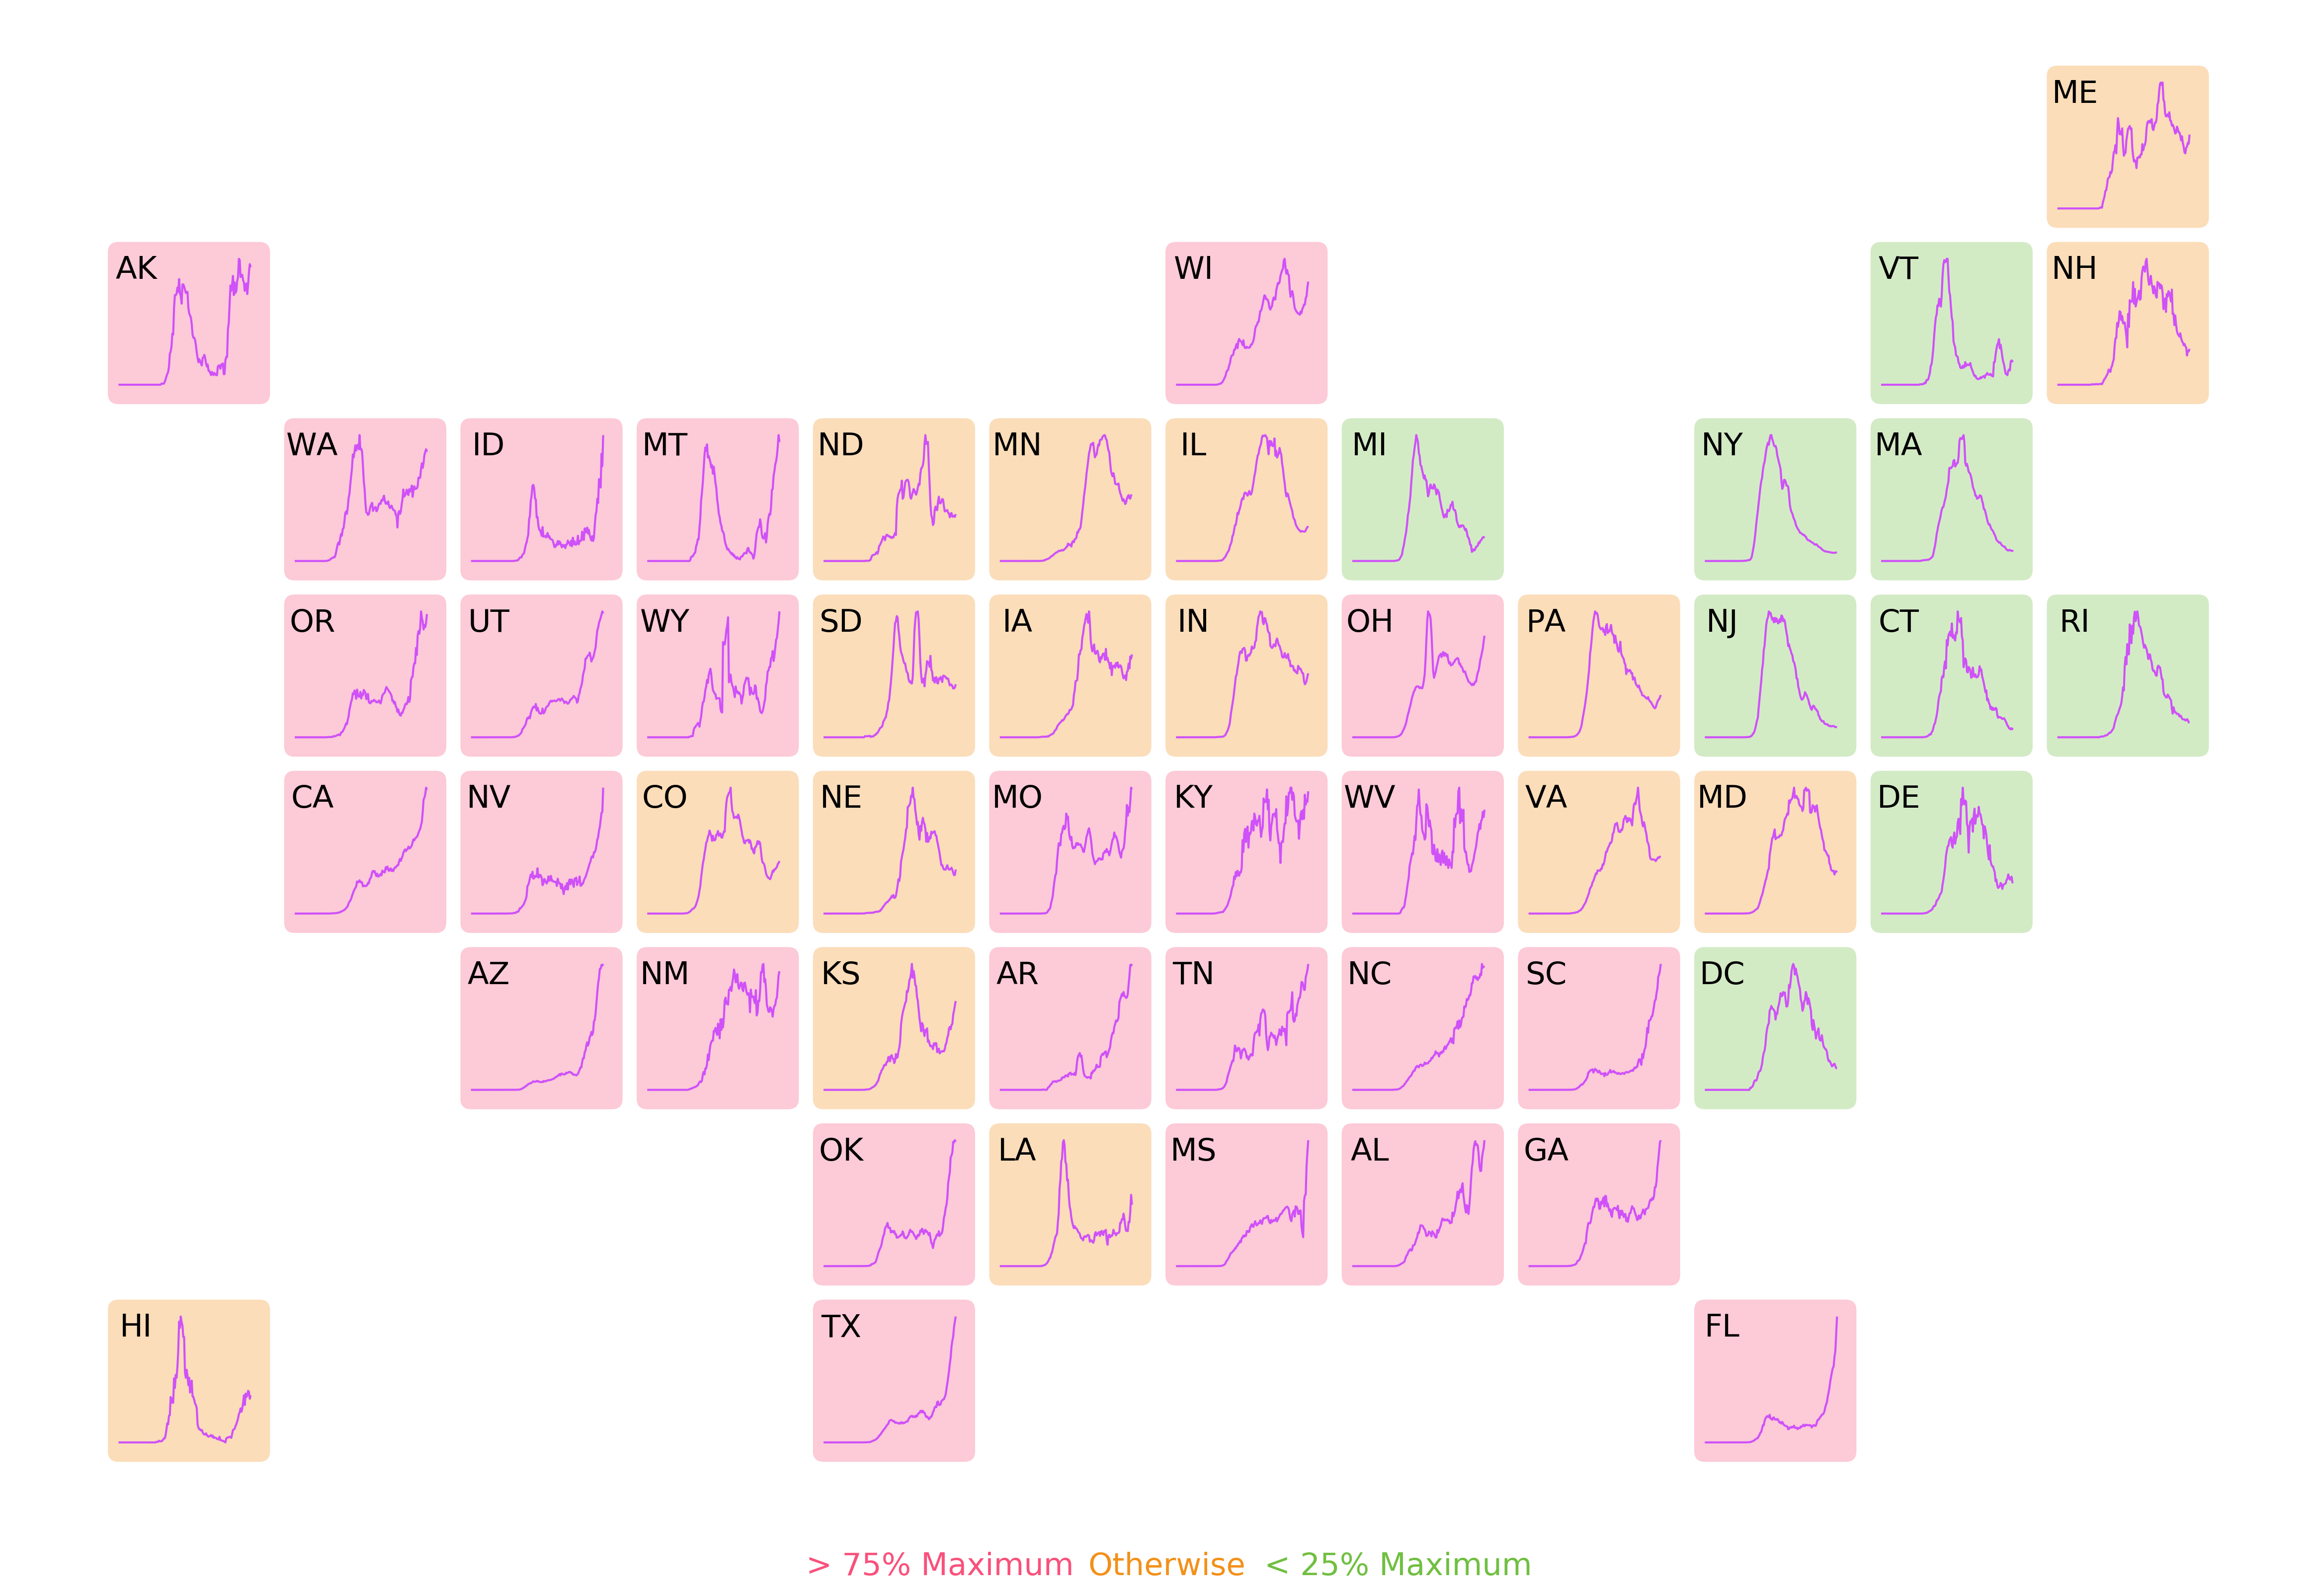

In [40]:
fig, ax = plt.subplots(1, figsize=(16, 22))
ax.set_aspect(1.)
ax.invert_yaxis()

patches = []
color_list = []

x = np.linspace(0., 0.75, confirmed_US.shape[0])

for state in states.index:
    daily = confirmed_US[state_dict[state]].diff(1).rolling(7).mean()
    
    timeline = (daily/daily.max()).fillna(0).values
    color = colors[3]
    
    if timeline[-1] > 0.75:
        color = colors[5]
    elif timeline[-1] < 0.25:
        color = colors[2]
    
    fancybox = mpatches.FancyBboxPatch([states.x[state]-0.5, states.y[state]-0.5], 0.8, 0.8,
                                        boxstyle=mpatches.BoxStyle("Round", pad=0.06))
    patches.append(fancybox)
    color_list.append(color)
    
    ax.text(y=states.y[state]-0.4, x=states.x[state]-0.4, 
            s=state, horizontalalignment='center', verticalalignment='center', fontsize=15)
    ax.plot(states.x[state]+x-0.5, states.y[state]-timeline/1.4+0.25, lw=1, color=colors[1])

collection = PatchCollection(patches, facecolors=color_list, alpha=0.3)
ax.add_collection(collection)

ax.text(x=3.4, y=8, s='> 75% Maximum', color=colors[5], fontsize=15, ha='left')
ax.text(x=5, y=8, s='Otherwise',     color=colors[3], fontsize=15, ha='left')
ax.text(x=6, y=8, s='< 25% Maximum', color=colors[2], fontsize=15, ha='left')

ax.axis('off')
fig.patch.set_facecolor('#FFFFFF')
fig.tight_layout()

### New York County Analysis

In [41]:
Top5 = list(NY.iloc[-1].sort_values(ascending=False).iloc[:5].index)

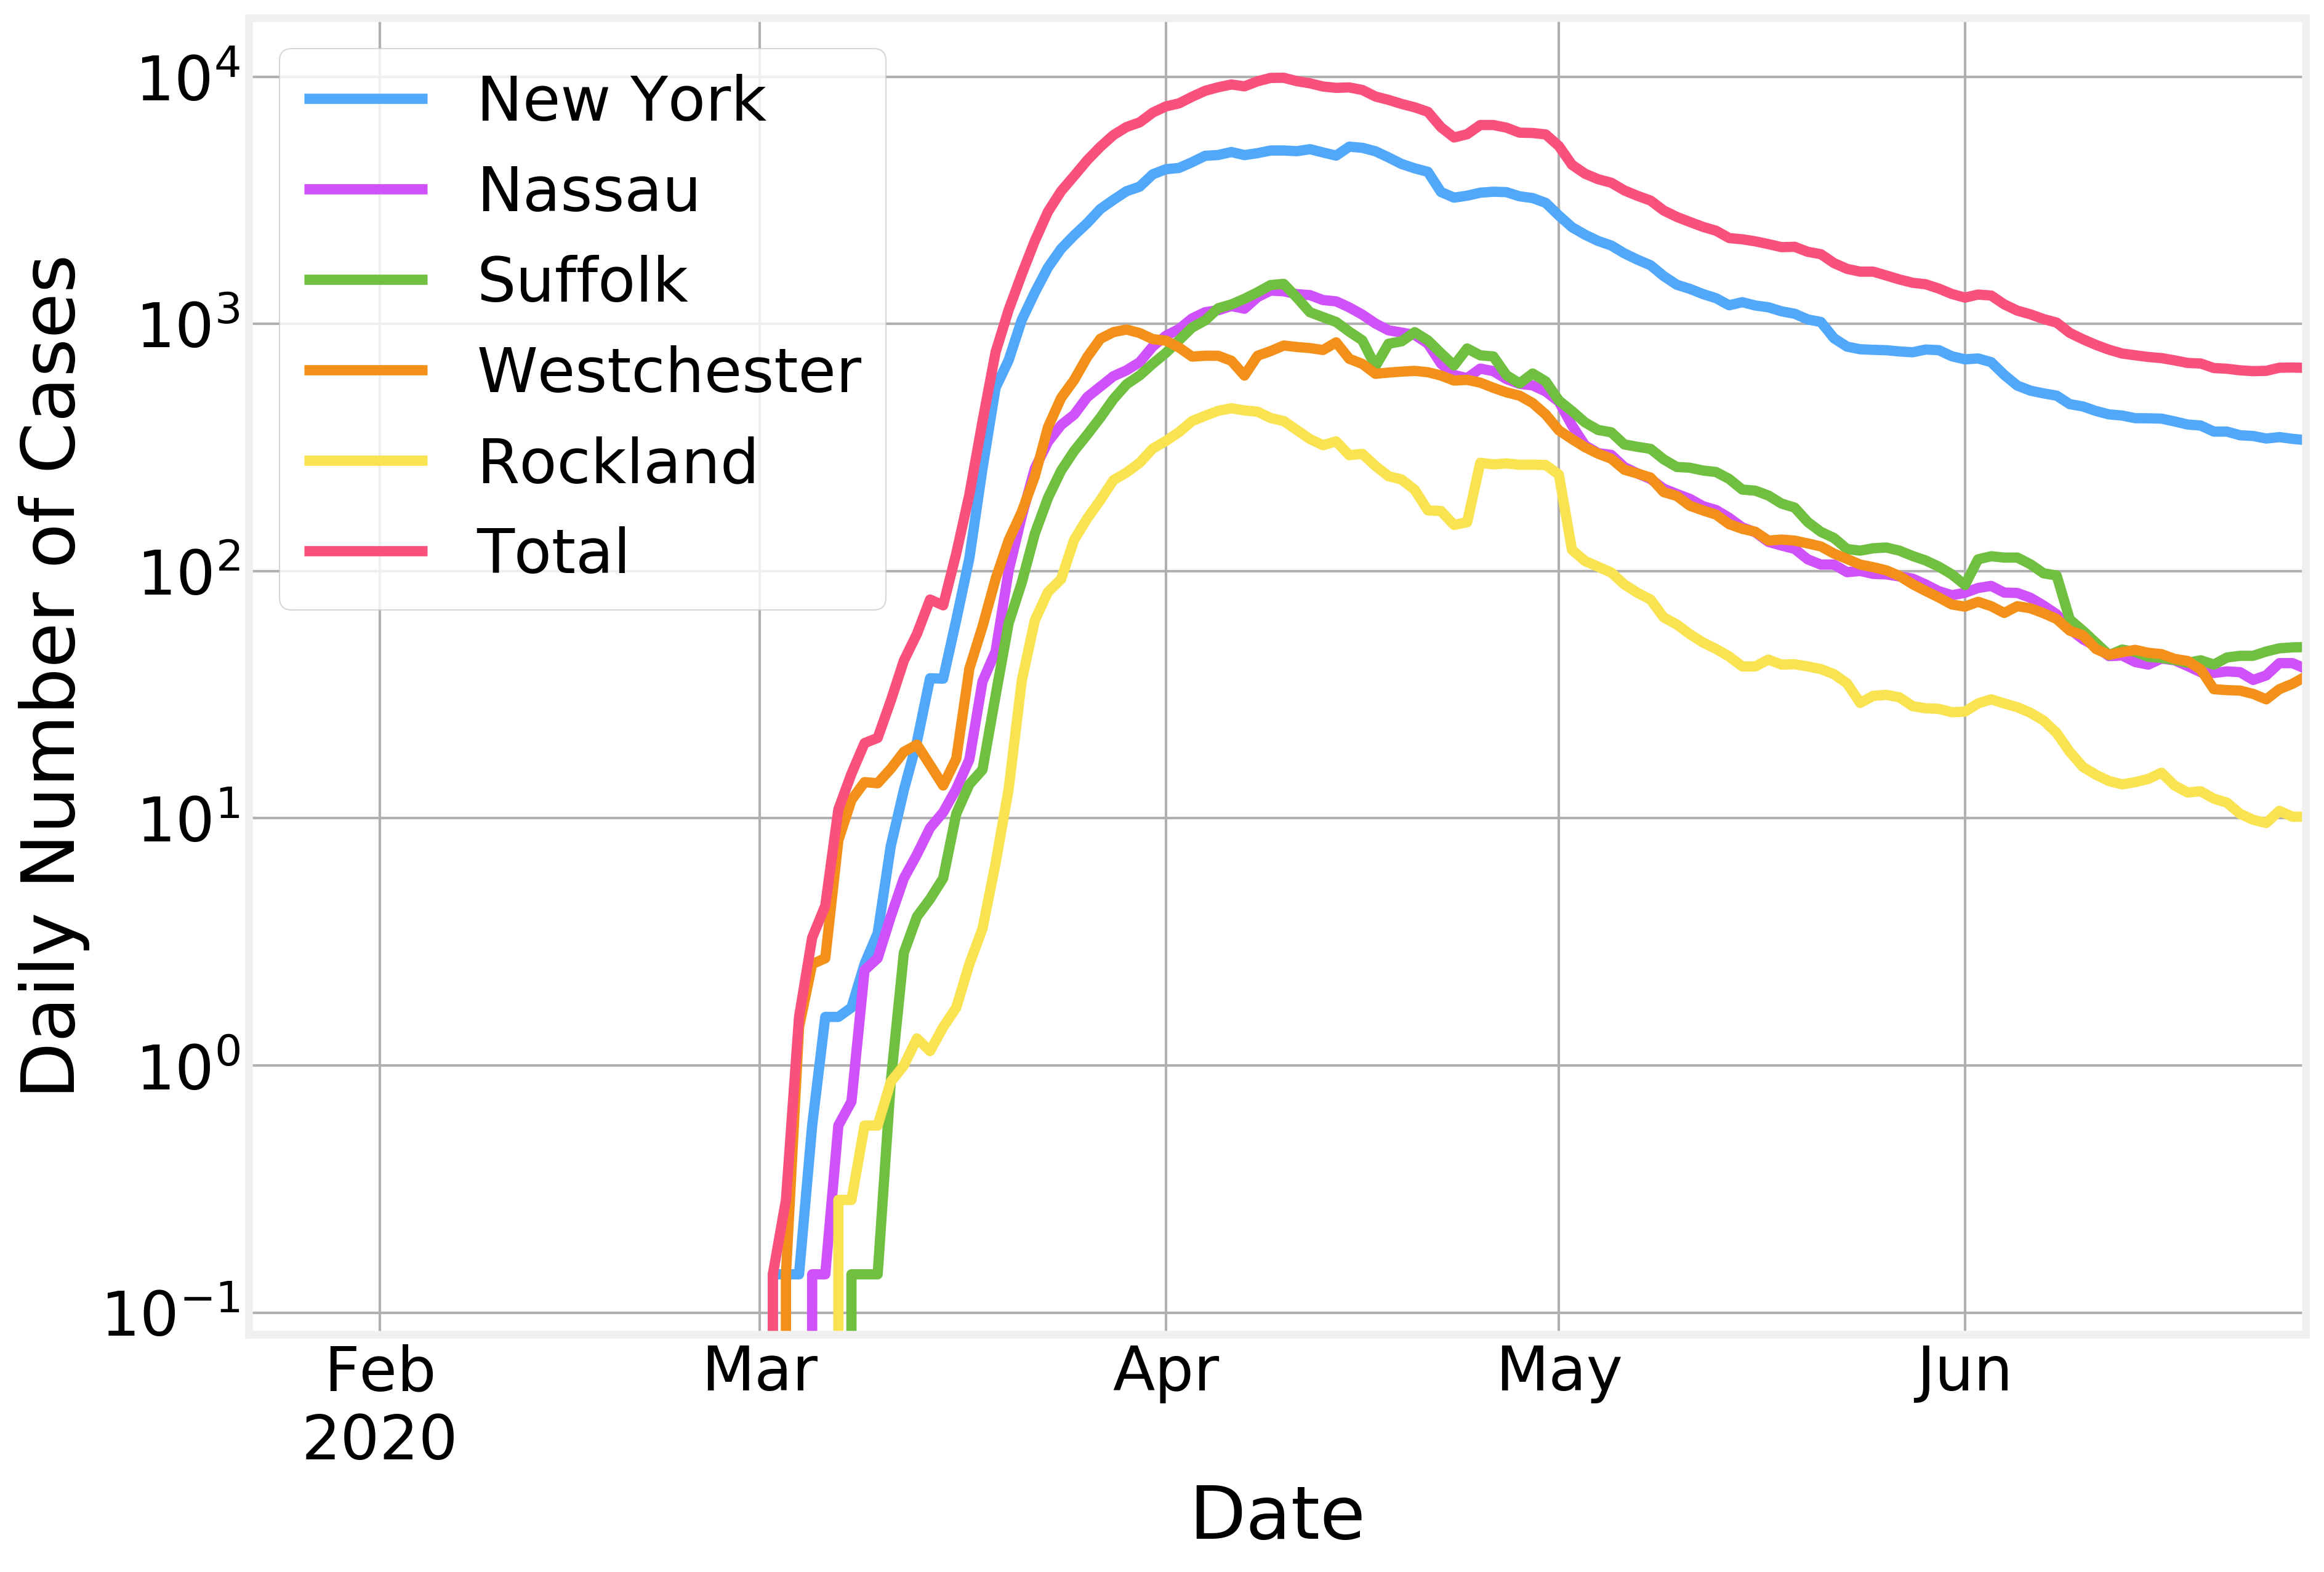

In [42]:
ax = NY[Top5].diff(1).rolling(7).mean().plot()
confirmed_US['New York'].diff(1).rolling(7).mean().plot(ax=ax, label='Total')

ax.set_xlabel('Date')
ax.set_ylabel('Daily Number of Cases')

ax.set_yscale('log')
ax.legend()

Different counties naturally have different peak times

In [43]:
Top5_peaks = pd.DataFrame(NY[Top5].diff(1).rolling(7).mean().idxmax(), columns=['Peak'])
Top5_peaks = pd.concat([Top5_peaks, 
             pd.DataFrame(confirmed_US[['New York']].diff(1).rolling(7).mean().idxmax().values, 
                          columns=['Peak'], index=['Total'])])
Top5_peaks            

Peak
New York    2020-04-15
Nassau      2020-04-09
Suffolk     2020-04-10
Westchester 2020-03-29
Rockland    2020-04-06
Total       2020-04-10

<div style="width: 100%; overflow: hidden;">
     <img src="data/D4Sci_logo_full.png" alt="Data For Science, Inc" align="center" border="0" width=300px> 
</div>